In [1]:
import os
import time
import numpy as np
import h5py
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

from scipy.stats import spearmanr, pearsonr, ranksums

import gc

#PWM sequence logo and score visualization code
import matplotlib

import matplotlib.cm as cm
import matplotlib.colors as colors
import colorsys

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot a sequence logo of a PWM
def plot_pwm(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    #Conservation = Max_Bits - Entropy
    conservation = 2. - np.sum(-pwm * np.log2(pwm + 1e-6), axis=1)
    
    #Loop over sequence positions
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        #Loop over nucleotide identities
        for ii in range(0, 4) :
            i = sort_index[ii]

            #Calculate prob * conservation
            nt_prob = pwm[j, i] * conservation[j]

            #Decode letter from nucleotide identity
            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            #Draw letter at position (height proportional to conservation)
            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height  * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    #Remove x-axis ticks
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#Function to interpolate color
def lighten_color(color, amount=0.5):
    try:
        c = colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

#Function to plot pwms and gradient saliency distributions for a collection of modisco metaclusters
def plot_modisco_interpretation(tissue_i, rasterize_dpi=None, y_min_fixed=None, y_max_fixed=None, tissue_colors=['red', 'darkorange', 'darkblue'], qtls=[0.50, 0.80, 0.95], shades=[1.0, 0.8, 0.6], markers=['o', 's', 'D'], fill_between=True, y_qtl=0.02, n_cols=5, col_width=1.5, n_motifs_per_tissue=10, plot_corrs=False, plot_all_corrs=False, save_figs=False, save_prefix='default_') :

    print("[Salient Motifs for Tissue = '" + tissue_names[tissue_i] + "']")
    print("")

    print("-- Motif PWMs --")
    
    #Loop over PWMs
    for pwm_i in range(len(pwms[tissue_i])) :
        print(pwm_configs[tissue_i][pwm_i][0])
        
        #Plot PWM sequence logo
        plot_pwm(pwms[tissue_i][pwm_i], figsize=(0.2 * pwms[tissue_i][pwm_i].shape[0], 1), y_min=0., y_max=2., plot_y_ticks=False, save_figs=save_figs, fig_name=save_prefix + tissue_names[tissue_i] + "_" + pwm_configs[tissue_i][pwm_i][0].replace("/", "_") + "_pwm")

    #Plot tissue-specific score distributions
    n_cols = min(n_cols, len(pwm_scores[tissue_i]))

    #Get global y-axis limits
    y_min = np.min([np.min(np.quantile(pwm_scores[tissue_i][pwm_i], q=y_qtl, axis=0)) for pwm_i in range(len(pwm_scores[tissue_i]))])
    y_max = np.max([np.max(np.quantile(pwm_scores[tissue_i][pwm_i], q=1. - y_qtl, axis=0)) for pwm_i in range(len(pwm_scores[tissue_i]))])

    n_rows = len(pwm_scores[tissue_i]) // n_cols + (1 if len(pwm_scores[tissue_i]) % n_cols > 0 else 0)

    print("-- Motif Score Distributions --")
    
    #Loop over motif rows
    for row_ix in range(n_rows) :

        #Plot score distribution for a batch of motifs
        f, ax = None, None
        if rasterize_dpi is None :
            f, ax = plt.subplots(1, n_cols, figsize=(col_width * n_cols, 4))
        else :
            f, ax = plt.subplots(1, n_cols, figsize=(col_width * n_cols, 4), dpi=rasterize_dpi)

        col_start = row_ix * n_cols
        
        #Structures to store pairwise gradient correlations
        r_mat = np.zeros((n_cols, len(tissue_names), len(tissue_names)))
        r_main = np.zeros((n_cols, len(tissue_names)))

        #Loop over motifs
        for pwm_i in range(col_start, col_start+n_cols) :
            
            print("Motif = '" + pwm_configs[tissue_i][pwm_i][0] + "'")
            
            col_i = pwm_i % n_cols
            
            main_tissue_ix = (pwm_i % (len(tissue_names) * n_motifs_per_tissue)) // n_motifs_per_tissue
            
            plt.sca(ax[col_i])
            
            if pwm_i >= len(pwm_scores[tissue_i]) :
                plt.axis('off')
                
                continue

            pwm_score = pwm_scores[tissue_i][pwm_i]

            n = pwm_score.shape[0]
            
            print(" - n = " + str(n))
            
            #Calculate two-sided wilcoxon p-values for main tissue vs other tissues
            if n > 10 :
                #Loop over (other) tissues
                for score_ix in range(pwm_score.shape[1]) :
                    if score_ix != main_tissue_ix :
                        s_val, p_val = ranksums(pwm_score[:, main_tissue_ix], pwm_score[:, score_ix], alternative='two-sided')
                        print(" - Wilcoxon p ('" + tissue_names[main_tissue_ix] + "' vs '" + tissue_names[score_ix] + "') = " + str('{:.2e}'.format(p_val)) + " (s = " + str(round(s_val, 2)) + ")")

            #Calculate pairwise gradient correlations
            
            #Loop over tissue pairs
            if n > 10 :
                for tissue_1_ix in range(pwm_score.shape[1]) :
                    for tissue_2_ix in range(tissue_1_ix + 1, pwm_score.shape[1]) :
                        r_mat[col_i, tissue_1_ix, tissue_2_ix] = spearmanr(pwm_score[:, tissue_1_ix], pwm_score[:, tissue_2_ix])[0]
                        r_mat[col_i, tissue_2_ix, tissue_1_ix] = r_mat[col_i, tissue_1_ix, tissue_2_ix]

            #Loop over tissues
            if n > 10 :
                for score_ix in range(pwm_score.shape[1]) :
                    r_main[col_i, score_ix] = r_mat[col_i, main_tissue_ix, score_ix]

            #Draw distribution plots
            if rasterize_dpi is None :
                sns.stripplot(data=pwm_score.T.tolist(), palette='dark:black', s=2, alpha=0.1, jitter=0.2)
            else :
                sns.stripplot(data=pwm_score.T.tolist(), palette='dark:black', s=2, alpha=0.1, jitter=0.2, rasterized=True)

            #Loop over and annotate score distributions per tissue
            for score_ix in range(pwm_score.shape[1]) :

                min_qtl_val = y_max

                #Loop over qtl limits
                for qtl_ix, qtl in enumerate(qtls) :

                    qtl_val = np.quantile(pwm_score[:, score_ix], q=qtl)
                    plt.plot([score_ix - 0.5, score_ix + 0.5], [qtl_val, qtl_val], color=lighten_color(tissue_colors[score_ix], shades[qtl_ix]), linewidth=1, linestyle='-', zorder=-1000)

                    #Draw markers
                    if pwm_i < n_cols - 1 or score_ix > 0 :
                        plt.scatter([score_ix - 0.5], [qtl_val], color=lighten_color(tissue_colors[score_ix], shades[qtl_ix]), s=30, edgecolor='black', linewidth=0.75, marker=markers[qtl_ix])
                    else :
                        plt.scatter([score_ix - 0.5], [qtl_val], color=lighten_color(tissue_colors[score_ix], shades[qtl_ix]), s=30, edgecolor='black', linewidth=0.75, marker=markers[qtl_ix], label=str(int(100. * qtl)) + 'th p.')

                    #Draw shaded area
                    if fill_between and qtl_ix > 0 :
                        plt.fill_between(
                            [score_ix - 0.5, score_ix + 0.5],
                            [prev_qtl_val, prev_qtl_val],
                            [qtl_val, qtl_val],
                            color=lighten_color(tissue_colors[score_ix], shades[qtl_ix]),
                            alpha=0.25
                        )

                    #Cache previous qtl value
                    prev_qtl_val = qtl_val

                    #Find smallest plotted qtl value
                    min_qtl_val = min(min_qtl_val, qtl_val)

                #Truncate at 0
                min_qtl_val = max(0., min_qtl_val)

                #Draw shaded area
                if fill_between and min_qtl_val > 0 :
                    plt.fill_between(
                        [score_ix - 0.5, score_ix + 0.5],
                        [0, 0],
                        [min_qtl_val, min_qtl_val],
                        color=lighten_color(tissue_colors[score_ix], max(shades[0] - 0.2, 0.2)),
                        alpha=0.25
                    )

            plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=-1000)

            #Define y-axis limits
            if y_min_fixed is None and y_max_fixed is None :
                plt.ylim(y_min, y_max)
            else :
                plt.ylim(y_min_fixed, y_max_fixed)

            #Set axis labels
            if col_i > 0 :
                plt.yticks([], [])
            else :
                plt.yticks(fontsize=8)
                plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

                plt.ylabel('Gradient Saliency (log2)', fontsize=8)

            plt.xticks(np.arange(pwm_score.shape[1]), tissue_names, fontsize=8, rotation=60)
            plt.xlim(-0.5, pwm_score.shape[1] - 0.5)

            #Set legend
            if col_i == n_cols - 1 :
                plt.legend(fontsize=8, loc='upper right')

            plt.title(pwm_configs[tissue_i][pwm_i][0] + "\n(n = " + str(n) + ")", fontsize=8)

        plt.tight_layout()

        #Save figure
        if save_figs :
            fig_name = save_prefix + tissue_names[tissue_i] + "_row_" + str(row_ix) + "_scores" + ("_rasterized" if rasterize_dpi is not None else "")

            if rasterize_dpi is None :
                plt.savefig(fig_name + ".png", transparent=True, dpi=600)
                plt.savefig(fig_name + ".eps")
            else :
                plt.savefig(fig_name + ".pdf")

        plt.show()
        
        if plot_all_corrs :
            #Visualize pairwise gradient correlations
            f, ax = plt.subplots(1, n_cols, figsize=(col_width * n_cols, col_width))

            col_start = row_ix * n_cols

            #Loop over motifs
            for pwm_i in range(col_start, col_start+n_cols) :

                col_i = pwm_i % n_cols
            
                main_tissue_ix = (pwm_i % (len(tissue_names) * n_motifs_per_tissue)) // n_motifs_per_tissue

                plt.sca(ax[col_i])

                if pwm_i >= len(pwm_scores[tissue_i]) :
                    plt.axis('off')

                    continue

                #Plot and annotate heatmap with spearman correlations
                plt.imshow(r_mat[col_i], cmap='bwr', vmin=-1.0, vmax=1.0, aspect='equal')

                for y in range(r_mat.shape[1]):
                    for x in range(r_mat.shape[2]):
                        if r_mat[col_i, y, x] != 0. and not np.isnan(r_mat[col_i, y, x]) :
                            plt.text(x, y, '%.2f' % r_mat[col_i, y, x], fontsize=8, horizontalalignment='center', verticalalignment='center')

                plt.xticks(np.arange(pwm_score.shape[1]), tissue_names, fontsize=8, rotation=30)
                plt.yticks(np.arange(pwm_score.shape[1]), tissue_names, fontsize=8, rotation=60)

                plt.title(pwm_configs[tissue_i][pwm_i][0], fontsize=8)

            plt.tight_layout()

            if save_figs :
                fig_name = save_prefix + tissue_names[tissue_i] + "_row_" + str(row_ix) + "_score_corrs"

                plt.savefig(fig_name + ".png", transparent=True, dpi=300)
                plt.savefig(fig_name + ".eps")

            plt.show()
        
        if plot_corrs :
            #Visualize pairwise gradient correlations (main tissue only)
            f, ax = plt.subplots(1, n_cols, figsize=(col_width * n_cols, col_width))

            col_start = row_ix * n_cols

            #Loop over motifs
            for pwm_i in range(col_start, col_start+n_cols) :

                col_i = pwm_i % n_cols

                main_tissue_ix = (pwm_i % (len(tissue_names) * n_motifs_per_tissue)) // n_motifs_per_tissue

                plt.sca(ax[col_i])

                if pwm_i >= len(pwm_scores[tissue_i]) :
                    plt.axis('off')

                    continue

                #Plot and annotate heatmap with spearman correlations
                plt.imshow(r_main[col_i, None, :], cmap='bwr', vmin=-1.0, vmax=1.0, aspect='equal')

                for x in range(r_main.shape[1]):
                    if r_main[col_i, x] != 0. and not np.isnan(r_main[col_i, x]) :
                        plt.text(x, 0., '%.2f' % r_main[col_i, x], fontsize=8, horizontalalignment='center', verticalalignment='center')

                plt.xticks(np.arange(pwm_score.shape[1]), tissue_names, fontsize=8, rotation=30)
                plt.yticks([0.], [tissue_names[main_tissue_ix]], fontsize=8, rotation=60)

                plt.title(pwm_configs[tissue_i][pwm_i][0], fontsize=8)

            plt.tight_layout()

            if save_figs :
                fig_name = save_prefix + tissue_names[tissue_i] + "_row_" + str(row_ix) + "_score_corrs_main"

                plt.savefig(fig_name + ".png", transparent=True, dpi=300)
                plt.savefig(fig_name + ".eps")

            plt.show()


In [2]:
#Load tissue-specific gene scores

tissues = [
    'blood',
    'blood',
]

score_files = [
    'scores_v2/gtex_blood_log2fc_undo_clip_scores_mean.h5',
    'scores_v2/gtex_k562_log2fc_undo_clip_scores_mean.h5',
]

gene_file = "/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv"

center_bp = 131072

tissue_dfs = []
tissue_seqs = []
tissue_scores = []

tissue_genes = []
tissue_chroms = []
tissue_strands = []
tissue_starts = []
tissue_ends = []

#Loop over tissue-specific genes and load scores
for tissue_i, tissue in enumerate(tissues) :
    
    print("Loading scores for tissue = '" + tissue + "'")
    
    #Load gene dataframe and select tissue
    gene_df = pd.read_csv(gene_file, sep='\t')
    gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
    gene_df = gene_df.drop(columns=['Unnamed: 0'])

    print("len(gene_df) = " + str(len(gene_df)))

    #Get list of gene for tissue
    tissue_genes_curr = gene_df['gene_base'].values.tolist()

    print("len(tissue_genes_curr) = " + str(len(tissue_genes_curr)))
    
    #Load contribution scores per tissue
    all_hyp_scores = []
    all_scores = []
    
    genes = None
    chrs = None
    strands = None
    starts = None
    ends = None
    
    #Load gradient h5 score files (for all output tissue tracks)
    for score_file_i, score_file in enumerate(score_files) :
        print("Loading score file = '" + score_file + "'")
        
        #Read h5 file
        with h5py.File(score_file, 'r') as scores_h5 :
            
            seq_len = scores_h5['grads'].shape[1]
            
            #Calculate relative positions to crop within
            pos_start = seq_len//2 - center_bp//2
            pos_end = pos_start + center_bp
            
            #Get hypothetical scores
            hyp_scores = scores_h5['grads'][:, pos_start:pos_end, :]
            seqs_1hot = scores_h5['seqs'][:, pos_start:pos_end]
            
            seq_genes = [gene.decode('UTF-8') for gene in scores_h5['gene']]
            
            #Get auxiliary information
            seq_strands = [strand.decode() for strand in scores_h5['strand']]
            seq_chrs = [chrom.decode() for chrom in scores_h5['chr']]

            seq_starts = np.array(scores_h5['start'][()] + pos_start, dtype='int32').tolist()
            seq_ends = np.array(scores_h5['end'][()] - (seq_len - pos_end), dtype='int32').tolist()

            #Filter out tissue-specific genes
            gene_dict = {gene.split(".")[0] : gene_i for gene_i, gene in enumerate(seq_genes)}

            #Get index of rows to keep
            keep_index = []
            for tissue_gene in tissue_genes_curr :
                keep_index.append(gene_dict[tissue_gene])

            #Filter/sub-select data
            hyp_scores = hyp_scores[keep_index, ...]
            seqs_1hot = seqs_1hot[keep_index, ...]
            
            #This information is identical for all output tissue tracks
            if score_file_i == 0 :
                genes = [seq_genes[k_ix] for k_ix in keep_index]
                chrs = [seq_chrs[k_ix] for k_ix in keep_index]
                strands = [seq_strands[k_ix] for k_ix in keep_index]
                starts = [seq_starts[k_ix] for k_ix in keep_index]
                ends = [seq_ends[k_ix] for k_ix in keep_index]
            
            #Aggregate over replicate tissue tracks
            hyp_scores = hyp_scores.mean(axis=-1, dtype='float32')
            
            #Get input-gated scores
            scores = np.multiply(hyp_scores, seqs_1hot)
            
            #Accumulate score tensor
            ##all_hyp_scores.append(hyp_scores[None, ...])
            all_scores.append(scores[None, ...])
            
            #Collect garbage
            gc.collect()
    
    #Construct tissue-specific score tensors
    ##hyp_scores = np.concatenate(all_hyp_scores, axis=0)
    scores = np.concatenate(all_scores, axis=0)
    
    #Accumulate data per tissue
    tissue_dfs.append(gene_df)
    tissue_seqs.append(seqs_1hot)
    tissue_scores.append(scores)
    
    tissue_genes.append(genes)
    tissue_chroms.append(chrs)
    tissue_strands.append(strands)
    tissue_starts.append(starts)
    tissue_ends.append(ends)
    
    #Collect garbage
    gc.collect()


Loading scores for tissue = 'blood'
len(gene_df) = 1000
len(tissue_genes_curr) = 1000
Loading score file = 'scores_v2/gtex_blood_log2fc_undo_clip_scores_mean.h5'
Loading score file = 'scores_v2/gtex_k562_log2fc_undo_clip_scores_mean.h5'
Loading scores for tissue = 'blood'
len(gene_df) = 1000
len(tissue_genes_curr) = 1000
Loading score file = 'scores_v2/gtex_blood_log2fc_undo_clip_scores_mean.h5'
Loading score file = 'scores_v2/gtex_k562_log2fc_undo_clip_scores_mean.h5'


In [3]:
#Load modisco result files

ic_t = 0.1
gc_content = 0.41

padding_bp = 0

e_thresh = 0.1

allow_dups = False

enforce_sign_consistency = True

tissue_names = [
    'blood',
    'k562',
]

modisco_files = [
    'gtex_log2fc_blood_40k_diff_4_folds/tfm.h5',
    'gtex_log2fc_k562_40k_diff_4_folds/tfm.h5',
]

modisco_signs = [
    1,
    1,
]

tsv_files = [
    'gtex_log2fc_blood_40k_diff_4_folds/tomtom_gtex_log2fc_blood_40k_diff_4_folds.tsv',
    'gtex_log2fc_k562_40k_diff_4_folds/tomtom_gtex_log2fc_k562_40k_diff_4_folds.tsv',
]

#Match motif display names to HOCOMOCO names
modisco_motifs = [
    [
        #Blood motifs
        ['SPI1/B', ['SPI1', 'SPIB']],
        ['CEBPA/B', ['CEBPA', 'CEBPB']],
        ['NFE2/JUN/D', ['NFE2', 'JUND', 'JUN']],
        ['GATA1/2/4', ['GATA1', 'GATA2', 'GATA4']],
        ['SOX2/3', ['SOX2', 'SOX3']],
        ['IRF1/2', ['IRF1', 'IRF2']],
        ['RUNX3', ['RUNX3']],
        ['IRF8', ['IRF8']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
    ],
    [
        #K562 motifs
        ['MYF6', ['MYF6']],
        ['STA5A/STAT1/4', ['STA5A', 'STAT1', 'STAT4']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
        ['(Empty)', ['EMPTYEMPTYEMPTY']],
    ],
]

#Parse .tsv files and map motifs to modisco clusters
pwm_configs = []

#Loop over tissues and load .tsv files
for tissue_i, tissue in enumerate(tissue_names) :
    
    print("Loading tomtom .tsv for tissue = '" + tissue + "'")
    
    tsv_df = pd.read_csv(tsv_files[tissue_i], sep='\t')
    
    #Filter on maximum allowed E-value
    tsv_df = tsv_df.loc[tsv_df['E-value'] <= e_thresh].copy().reset_index(drop=True)
    
    tsv_df['metacluster'] = tsv_df['Query_ID'].apply(lambda x: x.split("etacluster_")[1].split("_pattern")[0]).astype(int)
    tsv_df['pattern'] = tsv_df['Query_ID'].apply(lambda x: x.split("pattern_")[1]).astype(int)
    
    #Get positive and negative motif hits
    tsv_df_pos = tsv_df.loc[tsv_df['Query_ID'].str.contains(('metacluster_0' if modisco_signs[tissue_i] == 1 else 'metacluster_1'))].copy().reset_index(drop=True)
    tsv_df_neg = tsv_df.loc[tsv_df['Query_ID'].str.contains(('metacluster_1' if modisco_signs[tissue_i] == 1 else 'metacluster_0'))].copy().reset_index(drop=True)
    
    #Uniquely assign metaclusters to motif matches
    if not allow_dups :
        
        #Get flat list of motifs to search for
        modisco_motifs_flat = []
        modisco_prios_flat = []
        for tissue_j, _ in enumerate(tissue_names) :
            for [motif_name, motifs] in modisco_motifs[tissue_j] :
                for motif in motifs :
                    modisco_motifs_flat.append(motif)
                    modisco_prios_flat.append(1 if tissue_i == tissue_j else 2)
        
        #Filter positive cluster-motif rows
        keep_index = []
        prios = []
        for row_i, [_, row] in enumerate(tsv_df_pos.iterrows()) :
            
            found_hit = False
            found_prio = -1
            for motif, prio in zip(modisco_motifs_flat, modisco_prios_flat) :
                if motif in row['Target_ID'] :
                    found_hit = True
                    found_prio = prio
                    break
            
            if found_hit :
                keep_index.append(row_i)
                prios.append(found_prio)
        
        tsv_df_pos = tsv_df_pos.iloc[keep_index].copy().reset_index(drop=True)
        tsv_df_pos['prio'] = prios
        
        tsv_df_pos = tsv_df_pos.sort_values(by=[
            'metacluster',
            'pattern',
            'prio',
            'p-value',
        ], ascending=[
            True,
            True,
            True,
            True,
        ]).drop_duplicates(subset=['Query_ID'], keep='first').copy().reset_index(drop=True)
        
        #Filter negative cluster-motif rows
        keep_index = []
        prios = []
        for row_i, [_, row] in enumerate(tsv_df_neg.iterrows()) :
            
            found_hit = False
            found_prio = -1
            for motif, prio in zip(modisco_motifs_flat, modisco_prios_flat) :
                if motif in row['Target_ID'] :
                    found_hit = True
                    found_prio = prio
                    break
            
            if found_hit :
                keep_index.append(row_i)
                prios.append(found_prio)
        
        tsv_df_neg = tsv_df_neg.iloc[keep_index].copy().reset_index(drop=True)
        tsv_df_neg['prio'] = prios
        
        tsv_df_neg = tsv_df_neg.sort_values(by=[
            'metacluster',
            'pattern',
            'prio',
            'p-value',
        ], ascending=[
            True,
            True,
            True,
            True,
        ]).drop_duplicates(subset=['Query_ID'], keep='first').copy().reset_index(drop=True)
    
    used_dict = {}
    
    #Build pwm config
    
    tissue_config_pos = []
    tissue_config_neg = []
    
    #Loop over tissues
    for tissue_j, _ in enumerate(tissue_names) :
        
        #Loop over motif configurations related to tissue
        for [motif_name, motifs] in modisco_motifs[tissue_j] :

            pos_config = [motif_name + '_pos', [], [], []]
            pos_dict = {}

            neg_config = [motif_name + '_neg', [], [], []]
            neg_dict = {}

            #Loop over motif IDs belonging to the family of motifs
            for motif in motifs :

                #Get subset of positive hits
                pos_matches = tsv_df_pos.loc[tsv_df_pos['Target_ID'].str.contains(motif)]['Query_ID'].values.tolist()

                for pos_match in pos_matches :
                    if pos_match not in pos_dict and (allow_dups or pos_match not in used_dict) :
                        pos_config[1].append(pos_match)
                        pos_config[2].append(None)
                        pos_config[3].append(False)
                        pos_dict[pos_match] = True
                        used_dict[pos_match] = True

                #Get subset of negative hits
                neg_matches = tsv_df_neg.loc[tsv_df_neg['Target_ID'].str.contains(motif)]['Query_ID'].values.tolist()

                for neg_match in neg_matches :
                    if neg_match not in neg_dict and (allow_dups or neg_match not in used_dict) :
                        neg_config[1].append(neg_match)
                        neg_config[2].append(None)
                        neg_config[3].append(False)
                        neg_dict[neg_match] = True
                        used_dict[neg_match] = True

            tissue_config_pos.append(pos_config)
            tissue_config_neg.append(neg_config)
    
    pwm_configs.append(tissue_config_pos + tissue_config_neg)
    
    #Print pwm config
    for config in pwm_configs[-1] :
        print(str(config))
    
    print('')


#Verify that each metacluster is used only once
metaclusters = []

#Loop over tissues
for tissue_i, tissue_pwm_configs in enumerate(pwm_configs) :
    
    #Loop over pwm configs within tissue
    for pwm_i, pwm_config in enumerate(tissue_pwm_configs) :
        metaclusters.extend([
            'tissue_'  + str(tissue_i) + '_' + pwm_config[1][j]
            for j in range(len(pwm_config[1]))
        ])

print("len(metaclusters) = " + str(len(metaclusters)))
print("len(metaclusters) = " + str(len(set(metaclusters))) + " (unique)")
print("")

#Function to clip PWMs by IC
def ic_clip(pwm, threshold, background=[0.25]*4):
    
    pc = 0.001
    odds_ratio = ((pwm+pc)/(1+4*pc)) / (background[None,:])
    ic = (np.log((pwm+pc)/(1+4*pc)) / np.log(2))*pwm
    ic -= (np.log(background)*background/np.log(2))[None,:]
    ic_total = np.sum(ic,axis=1)[:,None]

    #No bp pass threshold
    if ~np.any(ic_total.flatten()>threshold):
        return None, 0, pwm.shape[0]
    else:
        left = np.where(ic_total>threshold)[0][0]
        right = np.where(ic_total>threshold)[0][-1]
        return pwm[left:(right+1)], left, right+1

pwms = []
pwm_scores = []
seqlet_dfs = []

#Loop over tissue-specific genes and load modisco results
for tissue_i, tissue in enumerate(tissue_names) :
    
    print("Loading modisco results for tissue = '" + tissue + "'")
    
    curr_pwms = []
    curr_scores = []
    curr_seqlet_dfs = []
    
    #Load h5 file
    with h5py.File(modisco_files[tissue_i], 'r') as tfm_h5 :
        
        #Loop over PWM/cluster configurations
        for pwm_i, [_, clusters, subclusters, rcs] in enumerate(pwm_configs[tissue_i]) :
            
            if not isinstance(clusters, list) :
                clusters = [clusters]
                subclusters = [subclusters]
                rcs = [rcs]
            
            #Empty cluster
            if len(clusters) == 0 :
                curr_pwms.append(np.ones((5, 4)) * 0.25)
                curr_scores.append(np.zeros((1, tissue_scores[tissue_i].shape[0])))
                curr_seqlet_dfs.append(pd.DataFrame({
                    'gene' : ['NO_GENE'],
                    'chrom' : ['chr1'],
                    'strand' : ['.'],
                    'start' : [-2],
                    'end' : [-1],
                    'seq' : ['N'],
                }))
                
                continue
            
            sub_scores = []
            sub_seqlet_dfs = []
            
            actual_subpwm_i = 0
            
            #Loop over modisco metaclusters belonging to the PWM config
            for subpwm_i, [cluster, subcluster, rc] in enumerate(zip(clusters, subclusters, rcs)) :
                
                metacluster_ix = int(cluster.split("etacluster_")[1].split("_pattern")[0])
                pattern_ix = int(cluster.split("pattern_")[1])
                
                #Get intended sign (check to see if metacluster is flipped)
                intended_sign = 0
                if (metacluster_ix == 0 and modisco_signs[tissue_i] == 1) or (metacluster_ix == 1 and modisco_signs[tissue_i] == -1) :
                    intended_sign = 1
                else :
                    intended_sign = -1

                #Get PWM
                pwm_unclipped = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['sequence']['fwd'][()]
                
                #Get PWM from subcluster indices, if defined
                if subcluster is not None :
                    pwm_unclipped = np.zeros(pwm_unclipped.shape)

                    total_n_seqlets = 0
                    
                    #Loop over subclusters
                    for subclust_i, subclust in enumerate(subcluster) :
                        n_seqlets = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['subcluster_to_subpattern'][subclust]['seqlets_and_alnmts']['seqlets'][()].shape[0]
                        pwm_unclipped += n_seqlets * tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['subcluster_to_subpattern'][subclust]['sequence']['fwd'][()]
                        total_n_seqlets += n_seqlets

                    pwm_unclipped /= total_n_seqlets

                #Calculate AT/GC background frequencies
                at_pct = (1-gc_content)/2
                gc_pct = gc_content/2
                background = np.array([at_pct, gc_pct, gc_pct, at_pct])

                #Clip by IC
                pwm, pwm_start, pwm_end = ic_clip(pwm_unclipped, ic_t, background)

                pwm_start = max(pwm_start-padding_bp, 0)
                pwm_end = min(pwm_end+padding_bp, pwm_unclipped.shape[0])

                #Accumulate tissue-specific contribution scores for motif hits
                
                #Extract seqlet strings
                seqlet_strs = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['seqlets_and_alnmts']['seqlets'][()]
                seqlet_strs = [seqlet_str.decode() for seqlet_str in seqlet_strs]
                
                #Optionally extract seqlet strings from subclusters
                if subcluster is not None :
                    seqlet_strs = []
                    
                    #Loop over subclusters
                    for subclust_i, subclust in enumerate(subcluster) :
                        subclust_seqlet_strs = tfm_h5["metacluster_idx_to_submetacluster_results"]['metacluster_' + str(metacluster_ix)]['seqlets_to_patterns_result']['patterns']['pattern_' + str(pattern_ix)]['subcluster_to_subpattern'][subclust]['seqlets_and_alnmts']['seqlets'][()]
                        subclust_seqlet_strs = [seqlet_str.decode() for seqlet_str in subclust_seqlet_strs]

                        seqlet_strs.extend(subclust_seqlet_strs)

                #Loop over tissue-specific scores and accumulate pwm importance
                imps = np.zeros((len(seqlet_strs), tissue_scores[tissue_i].shape[0]))

                #Also aggregate seqlet metadata
                seqlet_genes = []
                seqlet_chroms = []
                seqlet_strands = []
                seqlet_starts = []
                seqlet_ends = []

                seqlet_seqs = []

                #Loop over seqlets
                for seqlet_i, seqlet_str in enumerate(seqlet_strs) :

                    example_str, start_str, end_str, rc_str = seqlet_str.split(",")

                    #Extract seqlet info
                    example_ix = int(example_str.split(":")[1])
                    start = int(start_str.split(":")[1])
                    end = int(end_str.split(":")[1])
                    rc = bool(rc_str.split(":")[1])

                    #Get contribution scores overlapping seqlet coordinates
                    imps[seqlet_i, :] = np.sum(tissue_scores[tissue_i][:, example_ix, start+pwm_start:start+pwm_end, :], axis=(1, 2)) / float(pwm_end - pwm_start)

                    seqlet_genes.append(tissue_genes[tissue_i][example_ix])
                    seqlet_chroms.append(tissue_chroms[tissue_i][example_ix])
                    seqlet_strands.append(tissue_strands[tissue_i][example_ix])
                    seqlet_starts.append(tissue_starts[tissue_i][example_ix]+start+pwm_start)
                    seqlet_ends.append(tissue_starts[tissue_i][example_ix]+start+pwm_end)

                    seqlet_seq = ""
                    
                    #Loop over positions and decode argmax seqlet
                    for pos_j in range(pwm_start, pwm_end) :
                        argmax_nt = np.argmax(np.sum(np.abs(tissue_scores[tissue_i][:, example_ix, start+pos_j, :]), axis=0))
                        if argmax_nt == 0 :
                            seqlet_seq += 'A'
                        elif argmax_nt == 1 :
                            seqlet_seq += 'C'
                        elif argmax_nt == 2 :
                            seqlet_seq += 'G'
                        elif argmax_nt == 3 :
                            seqlet_seq += 'T'

                    seqlet_seqs.append(seqlet_seq)
                
                #Skip cluster if the median sign of the contribution scores disagree with the expected metacluster sign
                if enforce_sign_consistency and np.sign(np.median(imps[:, tissue_i])) != intended_sign :
                    print(" - Skipping '" + cluster + "' due to sign inconsistency.")
                    continue

                #Create seqlet dataframe
                seqlet_df = pd.DataFrame({
                    'gene' : seqlet_genes,
                    'chrom' : seqlet_chroms,
                    'strand' : seqlet_strands,
                    'start' : seqlet_starts,
                    'end' : seqlet_ends,
                    'seq' : seqlet_seqs,
                })
                
                #Append tissue-specific scores
                for ii in range(imps.shape[1]) :
                    seqlet_df['imp_' + str(ii)] = imps[:, ii]
                
                if actual_subpwm_i == 0 :
                    if not rc :
                        curr_pwms.append(pwm)
                    else :
                        curr_pwms.append(pwm[::-1, ::-1])
                
                sub_scores.append(imps)
                sub_seqlet_dfs.append(seqlet_df)
                
                actual_subpwm_i += 1
            
            #Append and accumulate scores and seqlet dataframes
            if len(sub_scores) > 0 :
                curr_scores.append(np.concatenate(sub_scores, axis=0))
                curr_seqlet_dfs.append(pd.concat(sub_seqlet_dfs).copy().reset_index(drop=True))
            else :
                
                #Empty motif cluster
                curr_pwms.append(np.ones((5, 4)) * 0.25)
                curr_scores.append(np.zeros((1, tissue_scores[tissue_i].shape[0])))
                curr_seqlet_dfs.append(pd.DataFrame({
                    'gene' : ['NO_GENE'],
                    'chrom' : ['chr1'],
                    'strand' : ['.'],
                    'start' : [-2],
                    'end' : [-1],
                    'seq' : ['N'],
                }))
    
    #Store PWMs and scores
    pwms.append(curr_pwms)
    pwm_scores.append(curr_scores)
    seqlet_dfs.append(curr_seqlet_dfs)


Loading tomtom .tsv for tissue = 'blood'
['SPI1/B_pos', ['metacluster_0_pattern_1', 'metacluster_0_pattern_29', 'metacluster_0_pattern_42'], [None, None, None], [False, False, False]]
['CEBPA/B_pos', ['metacluster_0_pattern_2', 'metacluster_0_pattern_47'], [None, None], [False, False]]
['NFE2/JUN/D_pos', ['metacluster_0_pattern_3'], [None], [False]]
['GATA1/2/4_pos', ['metacluster_0_pattern_8'], [None], [False]]
['SOX2/3_pos', ['metacluster_0_pattern_14'], [None], [False]]
['IRF1/2_pos', ['metacluster_0_pattern_22'], [None], [False]]
['RUNX3_pos', ['metacluster_0_pattern_13'], [None], [False]]
['IRF8_pos', ['metacluster_0_pattern_25', 'metacluster_0_pattern_37'], [None, None], [False, False]]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['MYF6_pos', [], [], []]
['STA5A/STAT1/4_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos', [], [], []]
['(Empty)_pos',

In [4]:
#Compute positive/negative-pooled score distributions

n_tissues = len(tissue_names)
n_motifs = 10

pwm_configs_pooled = []
pwms_pooled = []
pwm_scores_pooled = []
seqlet_dfs_pooled = []

#Loop over tissues
for tissue_i in range(n_tissues) :
    print("tissue = '" + tissue_names[tissue_i] + "'")
    
    pwm_config_pooled = []
    pwm_pooled = []
    pwm_score_pooled = []
    seqlet_df_pooled = []
    
    #Loop over motifs
    for pwm_i in range(n_tissues * n_motifs) :
        pwm_j = pwm_i + n_tissues * n_motifs
        
        print("Merging '" + pwm_configs[tissue_i][pwm_i][0] + "' and '" + pwm_configs[tissue_i][pwm_j][0] + "'.")
        
        #Merge configs
        pwm_config_pooled.append([
            pwm_configs[tissue_i][pwm_i][0][:-4] + '_pooled',
            pwm_configs[tissue_i][pwm_i][1] + pwm_configs[tissue_i][pwm_j][1],
            pwm_configs[tissue_i][pwm_i][2] + pwm_configs[tissue_i][pwm_j][2],
            pwm_configs[tissue_i][pwm_i][3] + pwm_configs[tissue_i][pwm_j][3],
        ])
        
        #Merge scores and seqlets
        pwm_pooled.append(pwms[tissue_i][pwm_i])
        pwm_score_pooled.append(np.concatenate([pwm_scores[tissue_i][pwm_i], pwm_scores[tissue_i][pwm_j]], axis=0))
        seqlet_df_pooled.append(pd.concat([seqlet_dfs[tissue_i][pwm_i], seqlet_dfs[tissue_i][pwm_j]]).copy().reset_index(drop=True))
    
    #Append merged results
    pwm_configs_pooled.append(pwm_config_pooled)
    pwms_pooled.append(pwm_pooled)
    pwm_scores_pooled.append(pwm_score_pooled)
    seqlet_dfs_pooled.append(seqlet_df_pooled)
    
    print("")

#Let the new results be the merged variables
pwm_configs = pwm_configs_pooled
pwms = pwms_pooled
pwm_scores = pwm_scores_pooled
seqlet_dfs = seqlet_dfs_pooled


tissue = 'blood'
Merging 'SPI1/B_pos' and 'SPI1/B_neg'.
Merging 'CEBPA/B_pos' and 'CEBPA/B_neg'.
Merging 'NFE2/JUN/D_pos' and 'NFE2/JUN/D_neg'.
Merging 'GATA1/2/4_pos' and 'GATA1/2/4_neg'.
Merging 'SOX2/3_pos' and 'SOX2/3_neg'.
Merging 'IRF1/2_pos' and 'IRF1/2_neg'.
Merging 'RUNX3_pos' and 'RUNX3_neg'.
Merging 'IRF8_pos' and 'IRF8_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging 'MYF6_pos' and 'MYF6_neg'.
Merging 'STA5A/STAT1/4_pos' and 'STA5A/STAT1/4_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.
Merging '(Empty)_pos' and '(Empty)_neg'.

tissue = 'k562'
Merging 'SPI1/B_pos' and 'SPI1/B_neg'.
Merging 'CEBPA/B_pos' and 'CEBPA/B_neg'.
Merging 'NFE2/JUN/D_pos' and 'NFE2/JUN/D_neg'.
Merging 'GATA1/2/4_

[Salient Motifs for Tissue = 'blood']

-- Motif PWMs --
SPI1/B_pooled


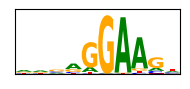

CEBPA/B_pooled


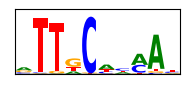

NFE2/JUN/D_pooled


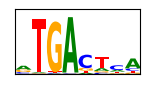

GATA1/2/4_pooled


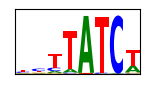

SOX2/3_pooled


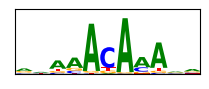

IRF1/2_pooled


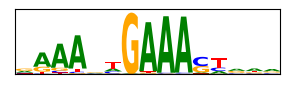

RUNX3_pooled


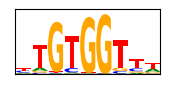

IRF8_pooled


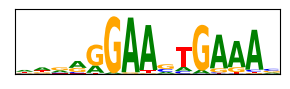

(Empty)_pooled


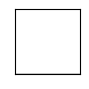

(Empty)_pooled


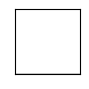

MYF6_pooled


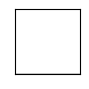

STA5A/STAT1/4_pooled


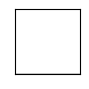

(Empty)_pooled


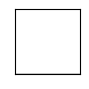

(Empty)_pooled


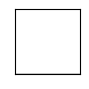

(Empty)_pooled


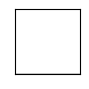

(Empty)_pooled


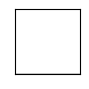

(Empty)_pooled


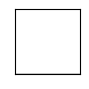

(Empty)_pooled


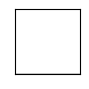

(Empty)_pooled


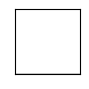

(Empty)_pooled


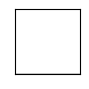

-- Motif Score Distributions --
Motif = 'SPI1/B_pooled'
 - n = 7916
 - Wilcoxon p ('blood' vs 'k562') = 2.60e-77 (s = 18.61)
Motif = 'CEBPA/B_pooled'
 - n = 5785
 - Wilcoxon p ('blood' vs 'k562') = 1.60e-304 (s = 37.3)
Motif = 'NFE2/JUN/D_pooled'
 - n = 6209
 - Wilcoxon p ('blood' vs 'k562') = 5.76e-06 (s = 4.53)
Motif = 'GATA1/2/4_pooled'
 - n = 2024
 - Wilcoxon p ('blood' vs 'k562') = 8.16e-30 (s = -11.34)
Motif = 'SOX2/3_pooled'
 - n = 1087
 - Wilcoxon p ('blood' vs 'k562') = 2.89e-05 (s = 4.18)


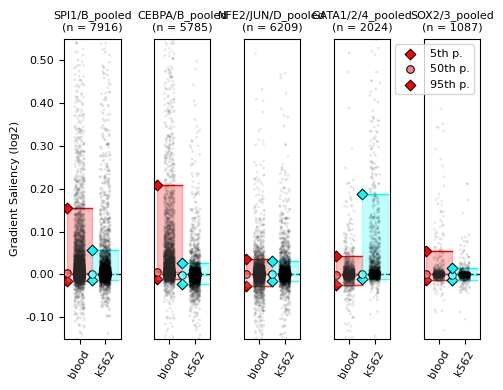

Motif = 'IRF1/2_pooled'
 - n = 505
 - Wilcoxon p ('blood' vs 'k562') = 1.37e-02 (s = 2.47)
Motif = 'RUNX3_pooled'
 - n = 847
 - Wilcoxon p ('blood' vs 'k562') = 8.61e-01 (s = 0.18)
Motif = 'IRF8_pooled'
 - n = 533
 - Wilcoxon p ('blood' vs 'k562') = 3.18e-03 (s = 2.95)
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


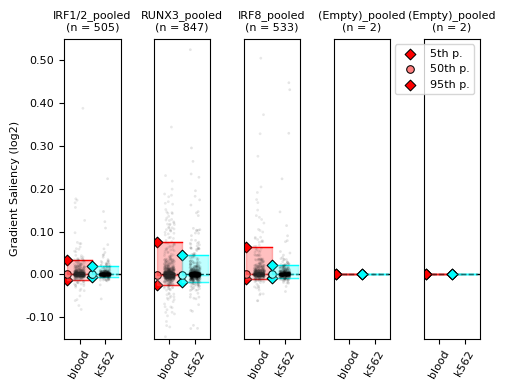

Motif = 'MYF6_pooled'
 - n = 501
 - Wilcoxon p ('k562' vs 'blood') = 2.27e-25 (s = 10.41)
Motif = 'STA5A/STAT1/4_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


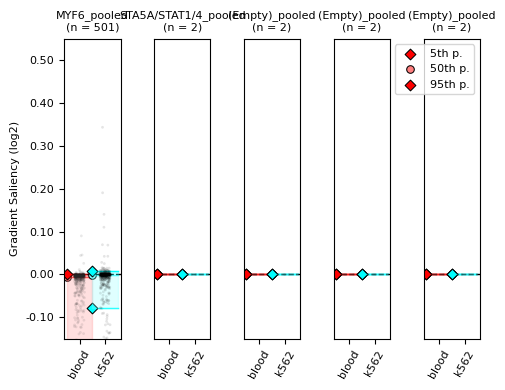

Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


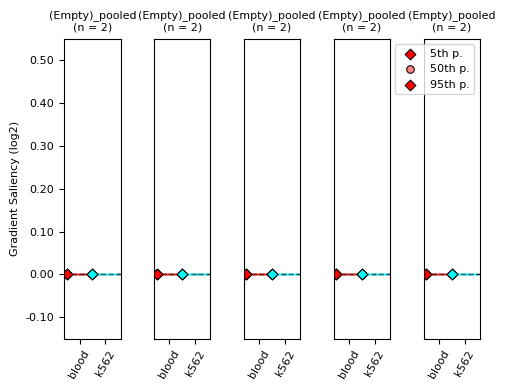

In [7]:
#Interpret blood-specific genes

plot_modisco_interpretation(
    tissue_i=0,
    tissue_colors=['red', 'cyan'],
    save_figs=False,
    save_prefix='attribution_figs/modisco_gtex_diff_40k_gaussian_blood_vs_k562_4_folds_diff_auto_pos_neg_pooled_',
    
    col_width=1,
    
    y_min_fixed=-0.15, y_max_fixed=0.55,
    
    qtls=[0.05, 0.50, 0.95],
    shades=[1.0, 0.5, 1.0],
    markers=['D', 'o', 'D'],
)


[Salient Motifs for Tissue = 'k562']

-- Motif PWMs --
SPI1/B_pooled


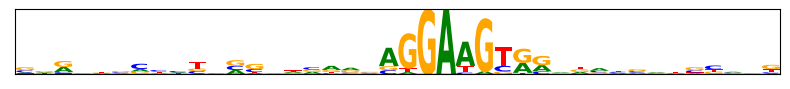

CEBPA/B_pooled


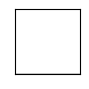

NFE2/JUN/D_pooled


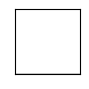

GATA1/2/4_pooled


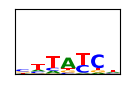

SOX2/3_pooled


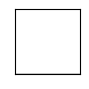

IRF1/2_pooled


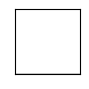

RUNX3_pooled


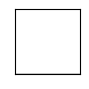

IRF8_pooled


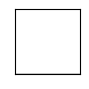

(Empty)_pooled


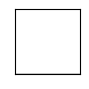

(Empty)_pooled


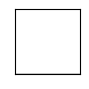

MYF6_pooled


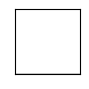

STA5A/STAT1/4_pooled


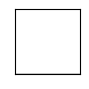

(Empty)_pooled


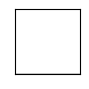

(Empty)_pooled


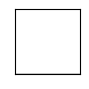

(Empty)_pooled


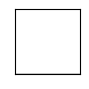

(Empty)_pooled


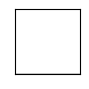

(Empty)_pooled


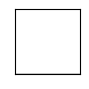

(Empty)_pooled


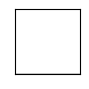

(Empty)_pooled


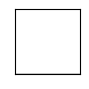

(Empty)_pooled


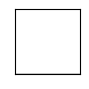

-- Motif Score Distributions --
Motif = 'SPI1/B_pooled'
 - n = 21
 - Wilcoxon p ('blood' vs 'k562') = 9.69e-02 (s = -1.66)
Motif = 'CEBPA/B_pooled'
 - n = 2
Motif = 'NFE2/JUN/D_pooled'
 - n = 2
Motif = 'GATA1/2/4_pooled'
 - n = 249
 - Wilcoxon p ('blood' vs 'k562') = 8.93e-05 (s = -3.92)
Motif = 'SOX2/3_pooled'
 - n = 2


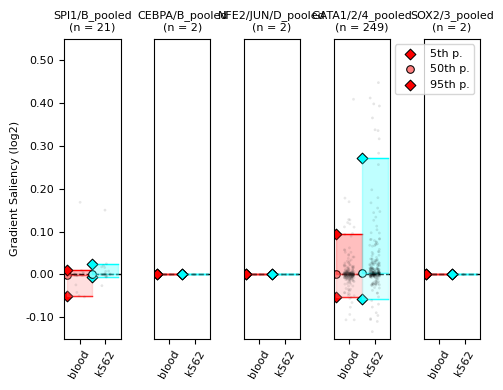

Motif = 'IRF1/2_pooled'
 - n = 2
Motif = 'RUNX3_pooled'
 - n = 2
Motif = 'IRF8_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


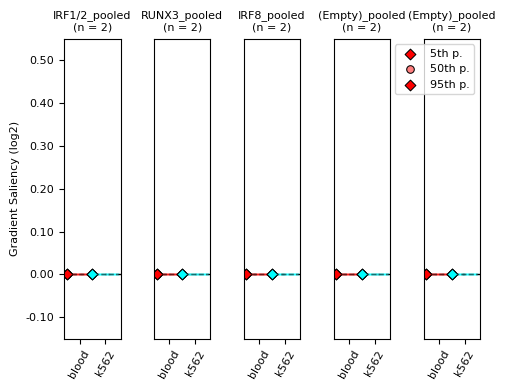

Motif = 'MYF6_pooled'
 - n = 2
Motif = 'STA5A/STAT1/4_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


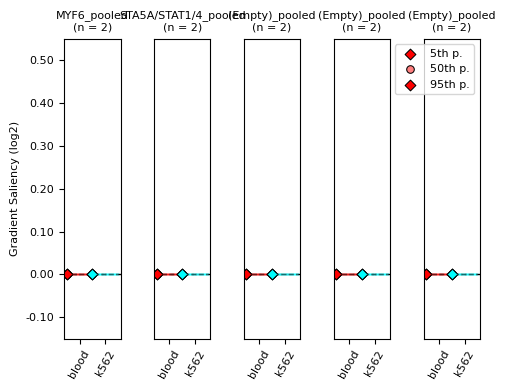

Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2
Motif = '(Empty)_pooled'
 - n = 2


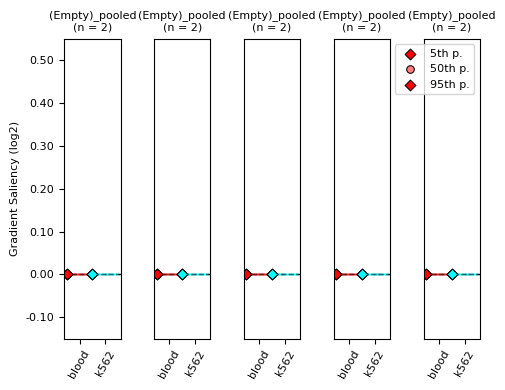

In [8]:
#Interpret blood-specific genes (also blood, but using clusters from k562 modisco results)

plot_modisco_interpretation(
    tissue_i=1,
    tissue_colors=['red', 'cyan'],
    save_figs=False,
    save_prefix='attribution_figs/modisco_gtex_diff_40k_gaussian_blood_vs_k562_4_folds_diff_auto_pos_neg_pooled_',
    
    col_width=1,
    
    y_min_fixed=-0.15, y_max_fixed=0.55,
    
    qtls=[0.05, 0.50, 0.95],
    shades=[1.0, 0.5, 1.0],
    markers=['D', 'o', 'D'],
)


In [5]:
#Compute tissue-pooled score distributions

n_tissues = len(tissue_names)
n_motifs = 10

pwm_configs_pooled = [[]]
pwms_pooled = [[]]
pwm_scores_pooled = [[]]
seqlet_dfs_pooled = [[]]

#Loop over PWMs
for pwm_i in range(n_tissues * n_motifs) :
    
    print("Pooling across tissues for motif = '" + pwm_configs[pwm_i // n_motifs][pwm_i][0] + "'")
    
    pwm_configs_pooled[0].append(pwm_configs[pwm_i // n_motifs][pwm_i])
    pwms_pooled[0].append(pwms[pwm_i // n_motifs][pwm_i])
    
    pwm_score_pooled = pwm_scores[0][pwm_i]
    seqlet_df_pooled = seqlet_dfs[0][pwm_i]
    
    #Loop over tissues and accumuluate scores
    for tissue_i in range(1, n_tissues) :
        pwm_score_pooled = np.concatenate([pwm_score_pooled, pwm_scores[tissue_i][pwm_i]], axis=0)
        seqlet_df_pooled = pd.concat([seqlet_df_pooled, seqlet_dfs[tissue_i][pwm_i]]).copy().reset_index(drop=True)
    
    pwm_scores_pooled[0].append(pwm_score_pooled)
    seqlet_dfs_pooled[0].append(seqlet_df_pooled)

pwm_configs = pwm_configs_pooled
pwms = pwms_pooled
pwm_scores = pwm_scores_pooled
seqlet_dfs = seqlet_dfs_pooled


Pooling across tissues for motif = 'SPI1/B_pooled'
Pooling across tissues for motif = 'CEBPA/B_pooled'
Pooling across tissues for motif = 'NFE2/JUN/D_pooled'
Pooling across tissues for motif = 'GATA1/2/4_pooled'
Pooling across tissues for motif = 'SOX2/3_pooled'
Pooling across tissues for motif = 'IRF1/2_pooled'
Pooling across tissues for motif = 'RUNX3_pooled'
Pooling across tissues for motif = 'IRF8_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = 'MYF6_pooled'
Pooling across tissues for motif = 'STA5A/STAT1/4_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling across tissues for motif = '(Empty)_pooled'
Pooling acro

In [6]:
#Drop overlapping/duplicate seqlets (an artifact from using the same gene set for both GTEx blood and k562 attributions)

import pyranges as pr

#Loop over motifs
for pwm_i in range(len(pwms[0])) :
    
    print("pwm_i = " + str(pwm_i))
    print(" - starting n = " + str(len(seqlet_dfs[0][pwm_i])))
    
    #Get seqlet dataframe
    seqlet_df = seqlet_dfs[0][pwm_i].rename(columns={
        'chrom' : 'Chromosome',
        'start' : 'Start',
        'end' : 'End',
    })
    seqlet_df['seqlet_id'] = np.arange(len(seqlet_df), dtype='int32')
    
    #Iteratively prune overlaps
    overlap_exists = True
    overlap_round = 1
    while overlap_exists :
        
        print(" - round = " + str(overlap_round))
        
        #Create pyrange object
        seqlet_pr = pr.PyRanges(seqlet_df)
        
        #Intersect against self, unstranded
        overlap_df = seqlet_pr.join(seqlet_pr, strandedness=False).df.copy().reset_index(drop=True)
        
        #If empty, stop
        if len(overlap_df) <= 0 :
            overlap_exists = False
            break
        
        overlap_df = overlap_df.query("seqlet_id != seqlet_id_b").copy().reset_index(drop=True)
        
        print(" - len(overlap_df) = " + str(len(overlap_df)))
        
        #If no overlap, stop
        if len(overlap_df) <= 0 :
            overlap_exists = False
            break
        
        overlap_ids = list(set(overlap_df['seqlet_id'].unique().tolist() + overlap_df['seqlet_id_b'].unique().tolist()))
        overlap_dict = {}
        for _, row in overlap_df.iterrows() :
            
            if row['seqlet_id'] not in overlap_dict :
                overlap_dict[row['seqlet_id']] = []
            
            if row['seqlet_id_b'] not in overlap_dict[row['seqlet_id']] :
                overlap_dict[row['seqlet_id']].append(row['seqlet_id_b'])
            
            if row['seqlet_id_b'] not in overlap_dict :
                overlap_dict[row['seqlet_id_b']] = []
            
            if row['seqlet_id'] not in overlap_dict[row['seqlet_id_b']] :
                overlap_dict[row['seqlet_id_b']].append(row['seqlet_id'])
        
        #Get seqlets without overlap
        seqlet_ids_no_overlap = seqlet_df.loc[~seqlet_df['seqlet_id'].isin(overlap_ids)]['seqlet_id'].values.tolist()
        
        #Pick seqlet ids from overlap
        chosen_seqlet_ids = seqlet_ids_no_overlap.copy()
        restricted_seqlet_ids = seqlet_ids_no_overlap.copy()
        for seqlet_id in overlap_ids :
            restricted_seqlet_id_set = set(restricted_seqlet_ids)
            
            #Only append seqlet id if not overlapping with previously chosen seqlets
            if seqlet_id not in restricted_seqlet_id_set :
                chosen_seqlet_ids.append(seqlet_id)
                restricted_seqlet_ids.extend([seqlet_id] + overlap_dict[seqlet_id])
        
        #Filter dataframe based on chosen seqlet ids
        seqlet_df = seqlet_df.loc[seqlet_df['seqlet_id'].isin(chosen_seqlet_ids)].copy().reset_index(drop=True)
        
        overlap_round += 1
    
    #Get final list of chosen seqlet_ids
    seqlet_ids = seqlet_df['seqlet_id'].values.tolist()
    
    #Filter seqlets from pwm data structures
    pwm_scores[0][pwm_i] = pwm_scores[0][pwm_i][seqlet_ids, :]
    seqlet_dfs[0][pwm_i] = seqlet_dfs[0][pwm_i].iloc[seqlet_ids].copy().reset_index(drop=True)
    
    print(" - final n = " + str(len(seqlet_dfs[0][pwm_i])))


pwm_i = 0
 - starting n = 7937
 - round = 1
 - len(overlap_df) = 1462
 - round = 2
 - len(overlap_df) = 0
 - final n = 7356
pwm_i = 1
 - starting n = 5787
 - round = 1
 - len(overlap_df) = 1206
 - round = 2
 - len(overlap_df) = 0
 - final n = 5288
pwm_i = 2
 - starting n = 6211
 - round = 1
 - len(overlap_df) = 832
 - round = 2
 - len(overlap_df) = 0
 - final n = 5866
pwm_i = 3
 - starting n = 2273
 - round = 1
 - len(overlap_df) = 286
 - round = 2
 - len(overlap_df) = 0
 - final n = 2148
pwm_i = 4
 - starting n = 1089
 - round = 1
 - len(overlap_df) = 108
 - round = 2
 - len(overlap_df) = 0
 - final n = 1045
pwm_i = 5
 - starting n = 507
 - round = 1
 - len(overlap_df) = 58
 - round = 2
 - len(overlap_df) = 0
 - final n = 483
pwm_i = 6
 - starting n = 849
 - round = 1
 - len(overlap_df) = 118
 - round = 2
 - len(overlap_df) = 0
 - final n = 797
pwm_i = 7
 - starting n = 535
 - round = 1
 - len(overlap_df) = 78
 - round = 2
 - len(overlap_df) = 0
 - final n = 500
pwm_i = 8
 - starting 

[Salient Motifs for Tissue = 'blood']

-- Motif PWMs --
SPI1/B_pooled


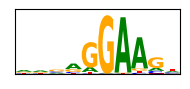

CEBPA/B_pooled


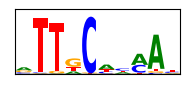

NFE2/JUN/D_pooled


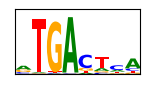

GATA1/2/4_pooled


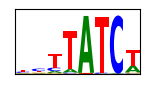

SOX2/3_pooled


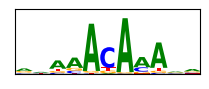

IRF1/2_pooled


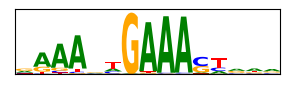

RUNX3_pooled


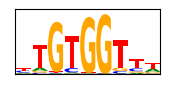

IRF8_pooled


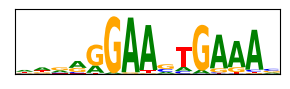

(Empty)_pooled


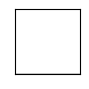

(Empty)_pooled


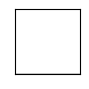

MYF6_pooled


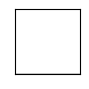

STA5A/STAT1/4_pooled


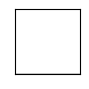

(Empty)_pooled


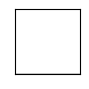

(Empty)_pooled


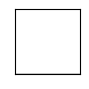

(Empty)_pooled


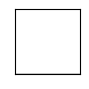

(Empty)_pooled


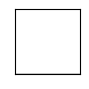

(Empty)_pooled


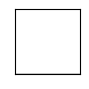

(Empty)_pooled


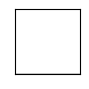

(Empty)_pooled


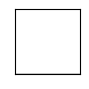

(Empty)_pooled


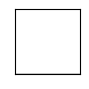

-- Motif Score Distributions --
Motif = 'SPI1/B_pooled'
 - n = 7356
 - Wilcoxon p ('blood' vs 'k562') = 1.18e-62 (s = 16.71)
Motif = 'CEBPA/B_pooled'
 - n = 5288
 - Wilcoxon p ('blood' vs 'k562') = 4.37e-254 (s = 34.05)
Motif = 'NFE2/JUN/D_pooled'
 - n = 5866
 - Wilcoxon p ('blood' vs 'k562') = 1.22e-04 (s = 3.84)
Motif = 'GATA1/2/4_pooled'
 - n = 2148
 - Wilcoxon p ('blood' vs 'k562') = 3.02e-28 (s = -11.02)
Motif = 'SOX2/3_pooled'
 - n = 1045
 - Wilcoxon p ('blood' vs 'k562') = 3.53e-05 (s = 4.14)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


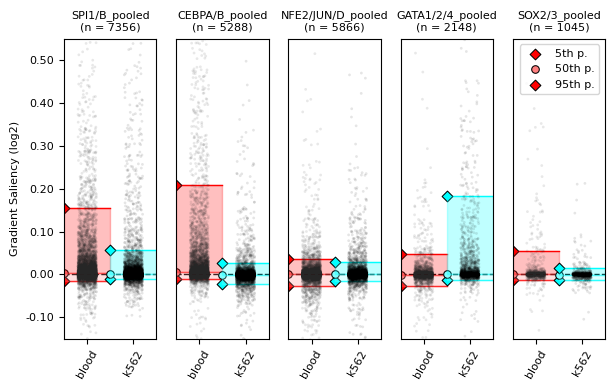

Motif = 'IRF1/2_pooled'
 - n = 483
 - Wilcoxon p ('blood' vs 'k562') = 5.57e-03 (s = 2.77)
Motif = 'RUNX3_pooled'
 - n = 797
 - Wilcoxon p ('blood' vs 'k562') = 7.37e-01 (s = 0.34)
Motif = 'IRF8_pooled'
 - n = 500
 - Wilcoxon p ('blood' vs 'k562') = 4.46e-03 (s = 2.84)
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


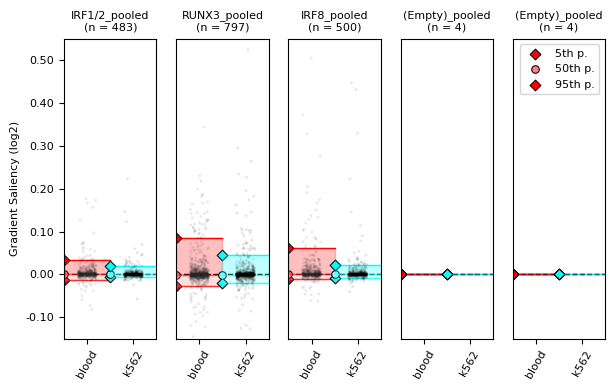

Motif = 'MYF6_pooled'
 - n = 495
 - Wilcoxon p ('k562' vs 'blood') = 2.65e-25 (s = 10.39)
Motif = 'STA5A/STAT1/4_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


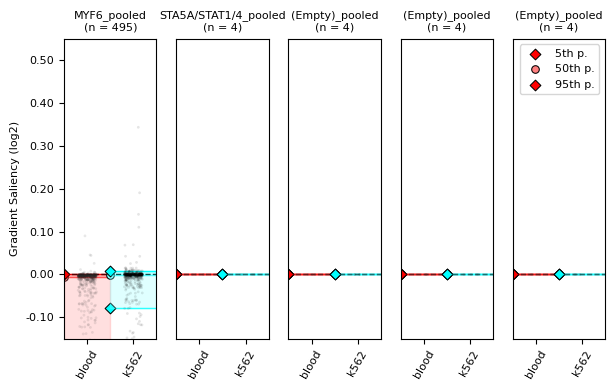

Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


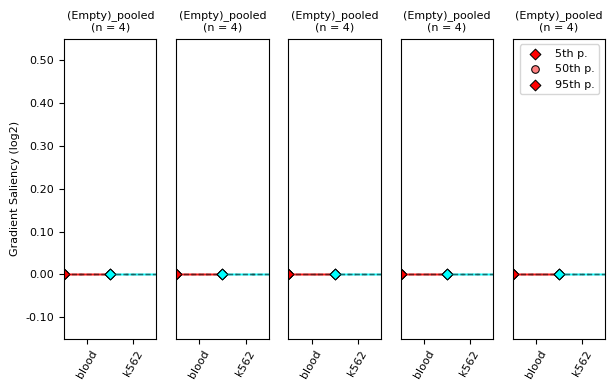

In [7]:
#Interpret pooled genes

plot_modisco_interpretation(
    tissue_i=0,
    tissue_colors=['red', 'cyan'],
    save_figs=True,
    save_prefix='attribution_figs/modisco_gtex_diff_40k_gaussian_blood_vs_k562_4_folds_diff_auto_tissue_pooled_',
    
    col_width=1.25,
    
    y_min_fixed=-0.15, y_max_fixed=0.55,
    
    qtls=[0.05, 0.50, 0.95],
    shades=[1.0, 0.5, 1.0],
    markers=['D', 'o', 'D'],
)


[Salient Motifs for Tissue = 'blood']

-- Motif PWMs --
SPI1/B_pooled


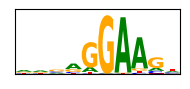

CEBPA/B_pooled


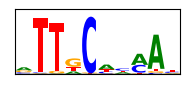

NFE2/JUN/D_pooled


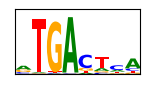

GATA1/2/4_pooled


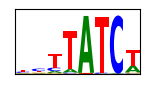

SOX2/3_pooled


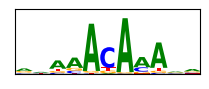

IRF1/2_pooled


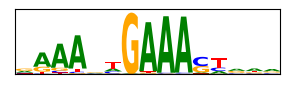

RUNX3_pooled


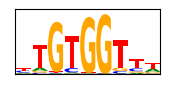

IRF8_pooled


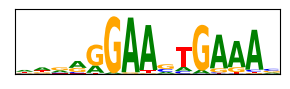

(Empty)_pooled


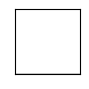

(Empty)_pooled


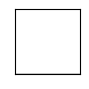

MYF6_pooled


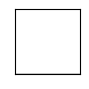

STA5A/STAT1/4_pooled


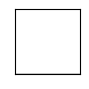

(Empty)_pooled


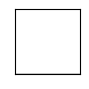

(Empty)_pooled


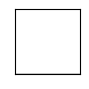

(Empty)_pooled


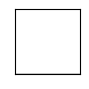

(Empty)_pooled


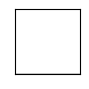

(Empty)_pooled


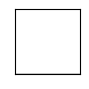

(Empty)_pooled


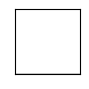

(Empty)_pooled


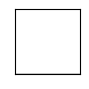

(Empty)_pooled


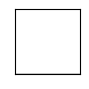

-- Motif Score Distributions --
Motif = 'SPI1/B_pooled'
 - n = 7356
 - Wilcoxon p ('blood' vs 'k562') = 1.18e-62 (s = 16.71)
Motif = 'CEBPA/B_pooled'
 - n = 5288
 - Wilcoxon p ('blood' vs 'k562') = 4.37e-254 (s = 34.05)
Motif = 'NFE2/JUN/D_pooled'
 - n = 5866
 - Wilcoxon p ('blood' vs 'k562') = 1.22e-04 (s = 3.84)
Motif = 'GATA1/2/4_pooled'
 - n = 2148
 - Wilcoxon p ('blood' vs 'k562') = 3.02e-28 (s = -11.02)
Motif = 'SOX2/3_pooled'
 - n = 1045
 - Wilcoxon p ('blood' vs 'k562') = 3.53e-05 (s = 4.14)


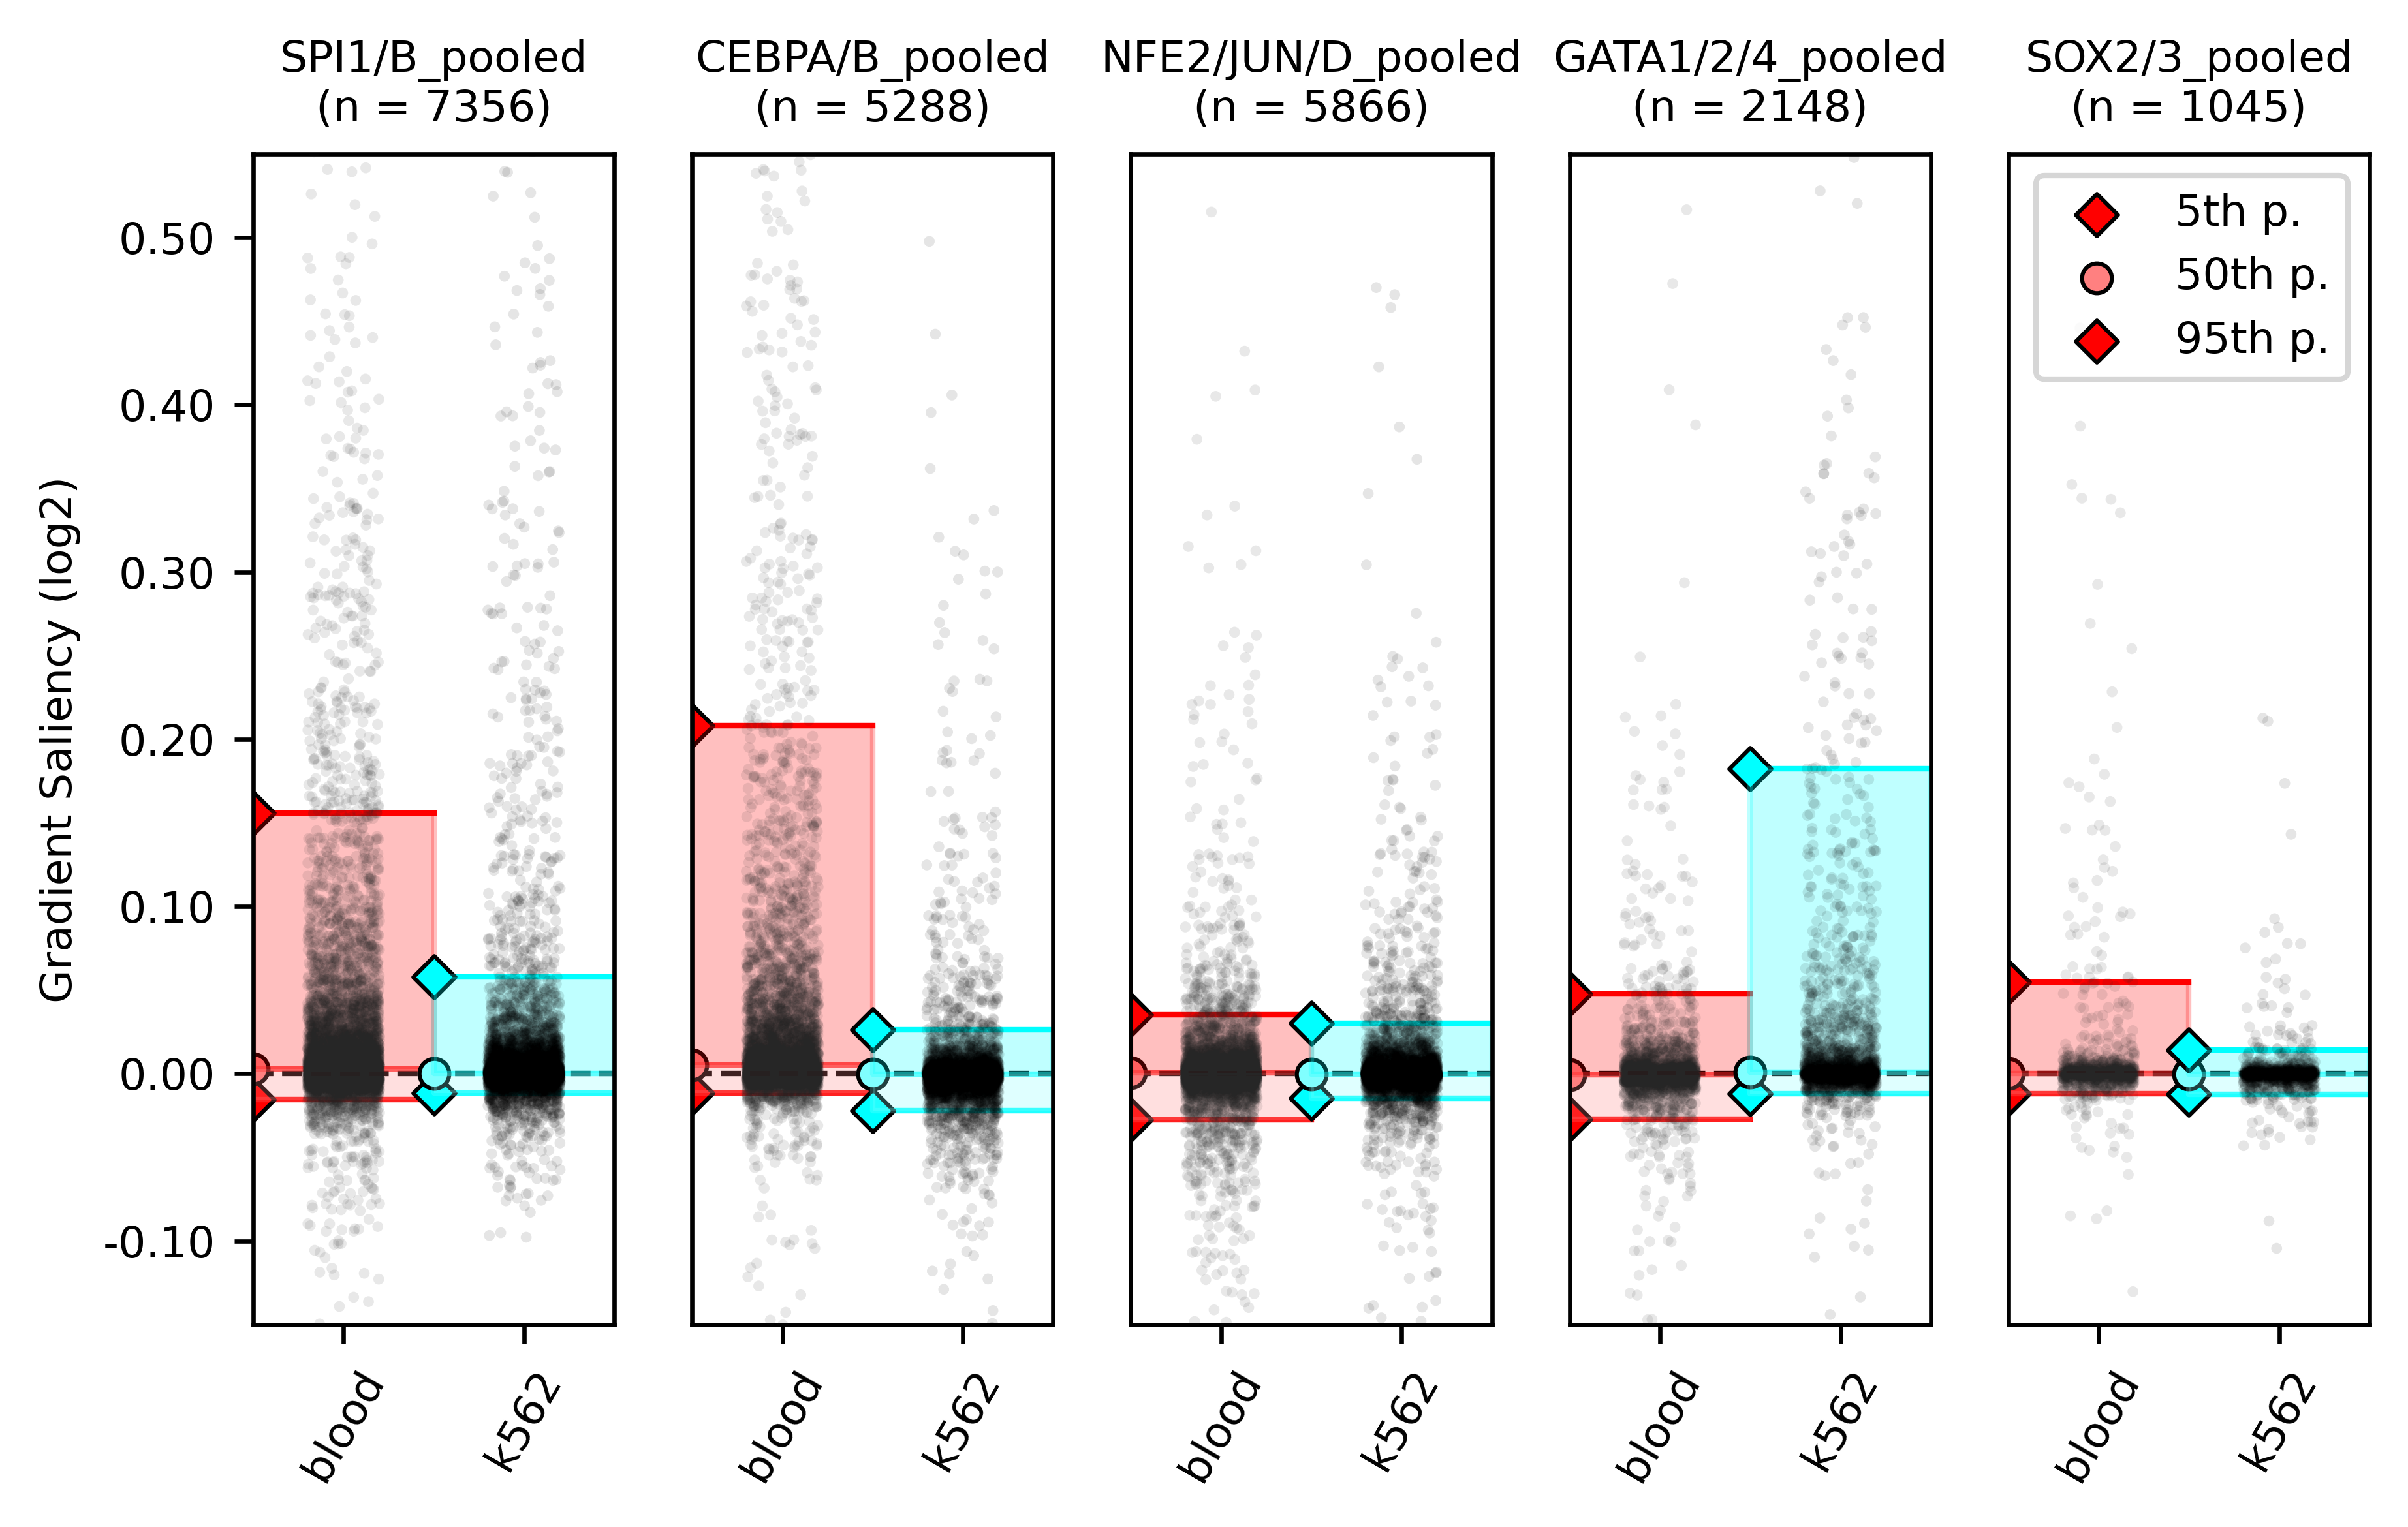

Motif = 'IRF1/2_pooled'
 - n = 483
 - Wilcoxon p ('blood' vs 'k562') = 5.57e-03 (s = 2.77)
Motif = 'RUNX3_pooled'
 - n = 797
 - Wilcoxon p ('blood' vs 'k562') = 7.37e-01 (s = 0.34)
Motif = 'IRF8_pooled'
 - n = 500
 - Wilcoxon p ('blood' vs 'k562') = 4.46e-03 (s = 2.84)
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


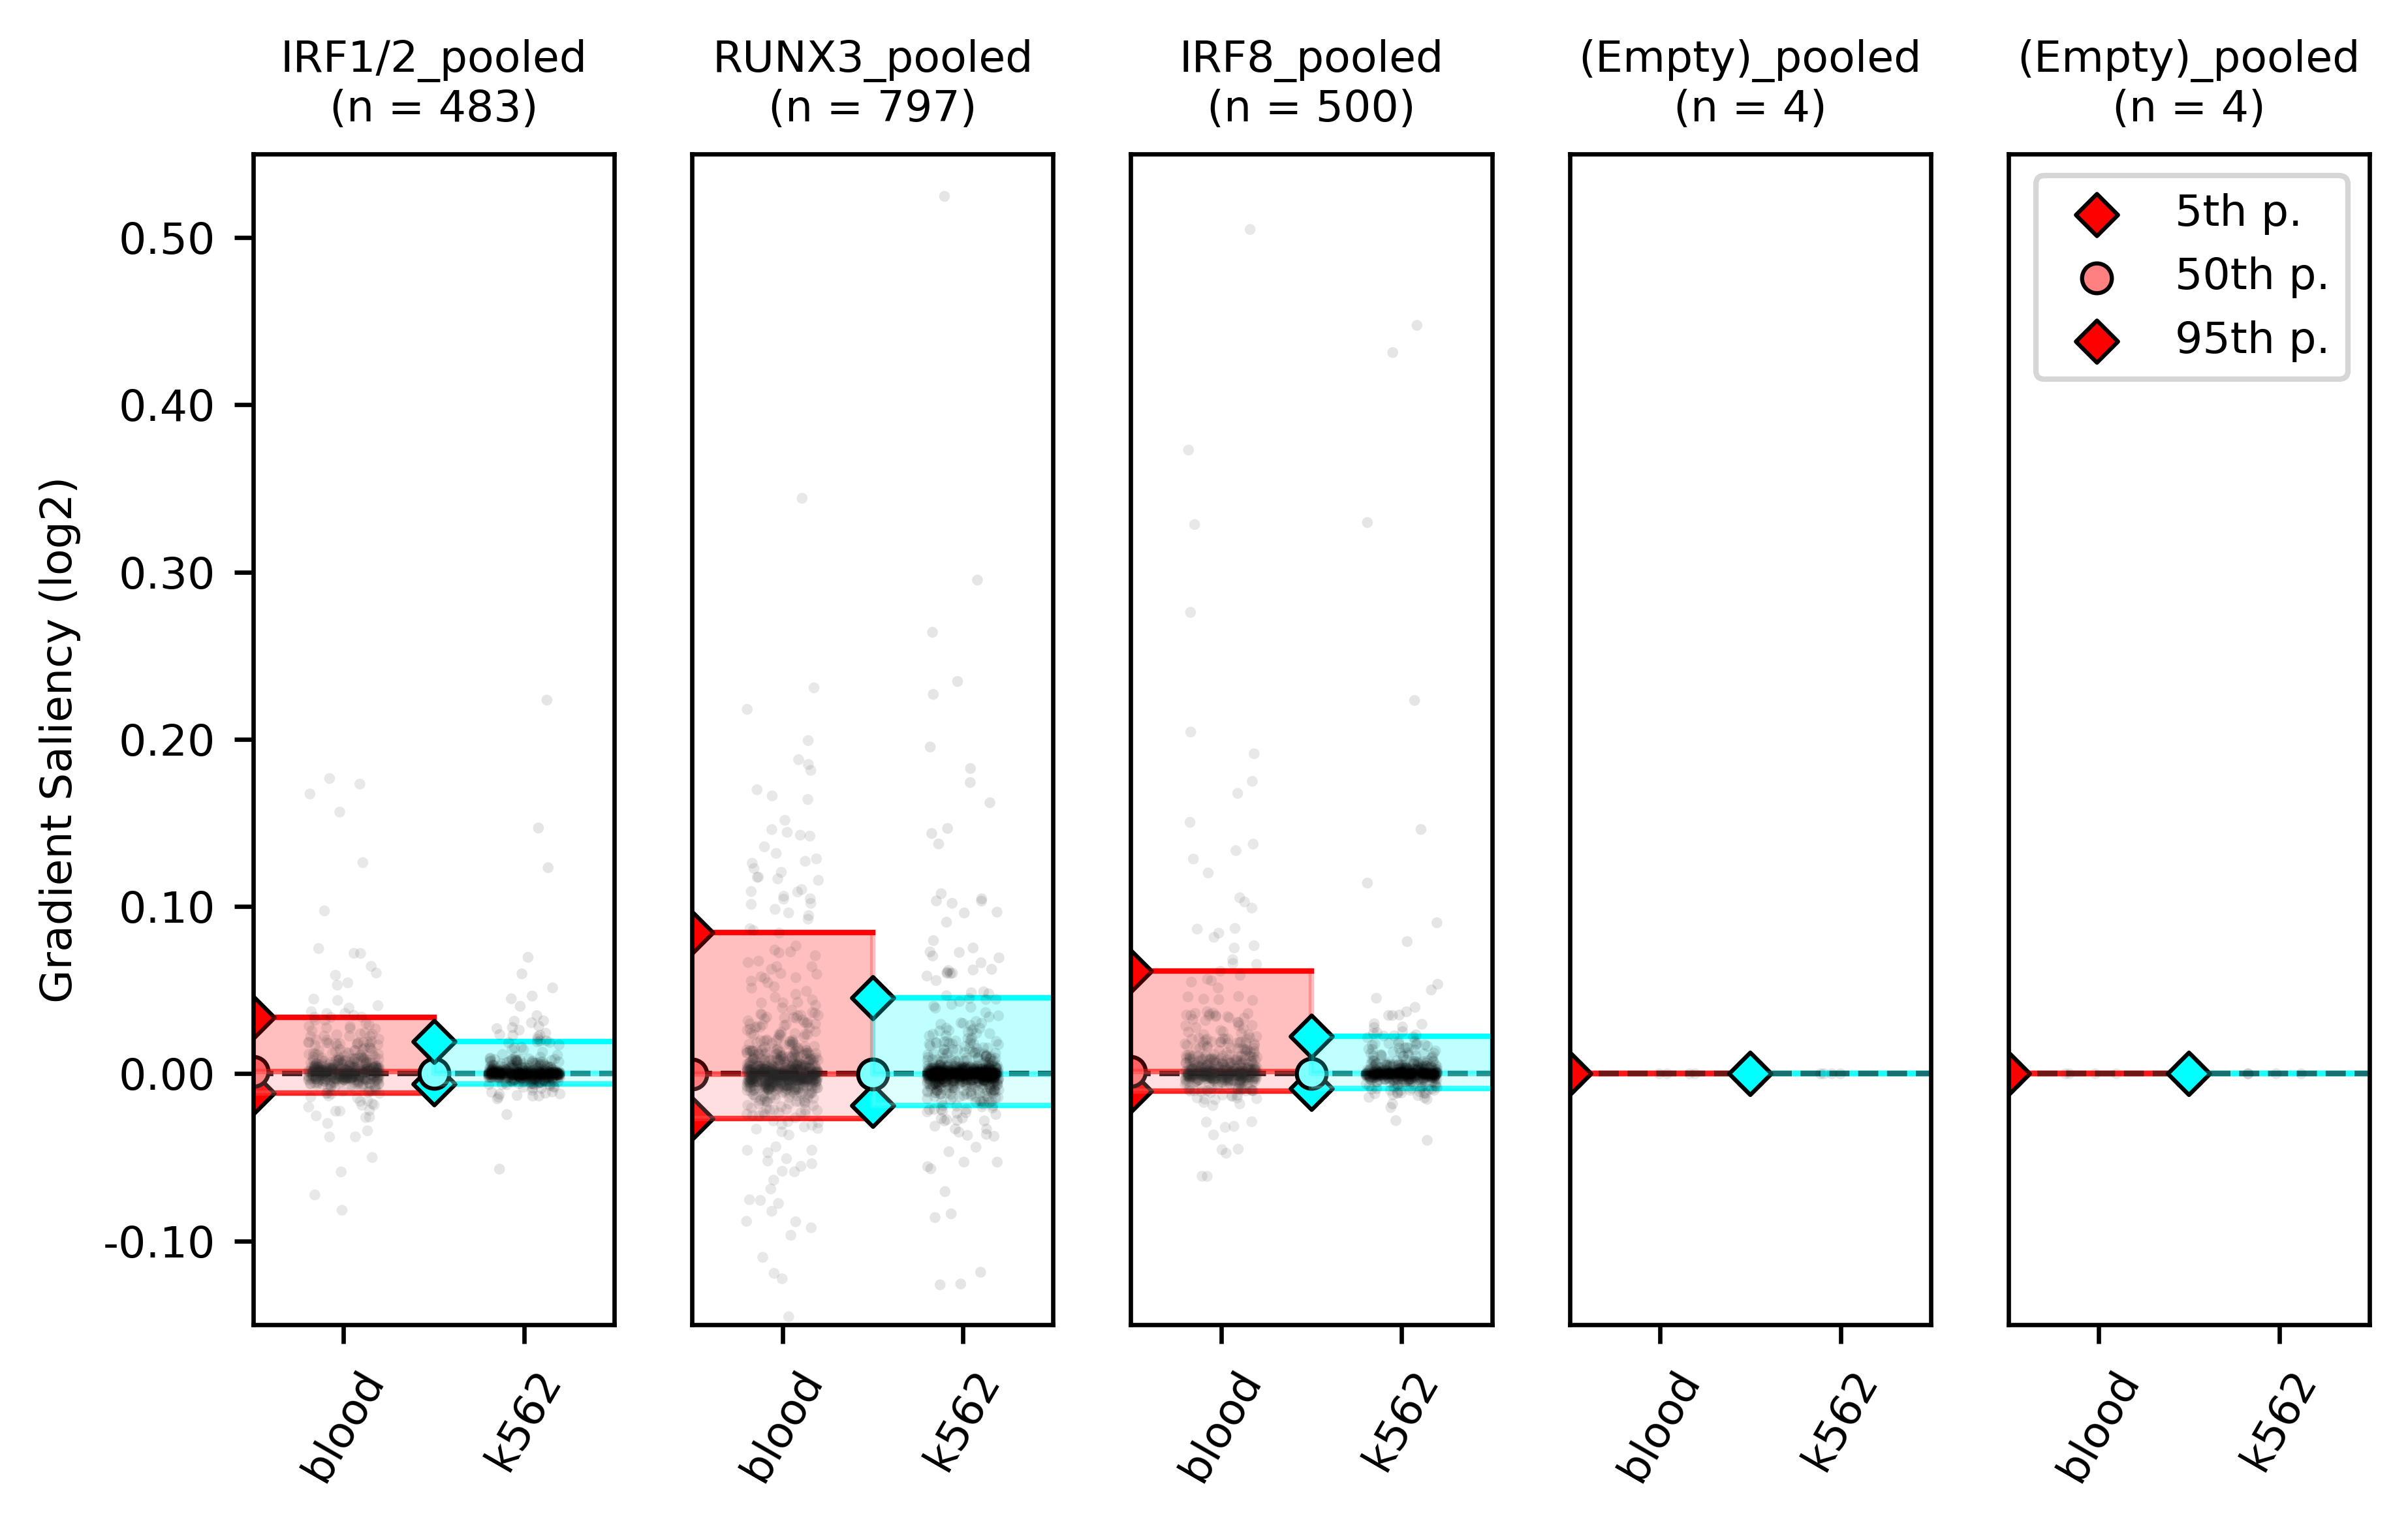

Motif = 'MYF6_pooled'
 - n = 495
 - Wilcoxon p ('k562' vs 'blood') = 2.65e-25 (s = 10.39)
Motif = 'STA5A/STAT1/4_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


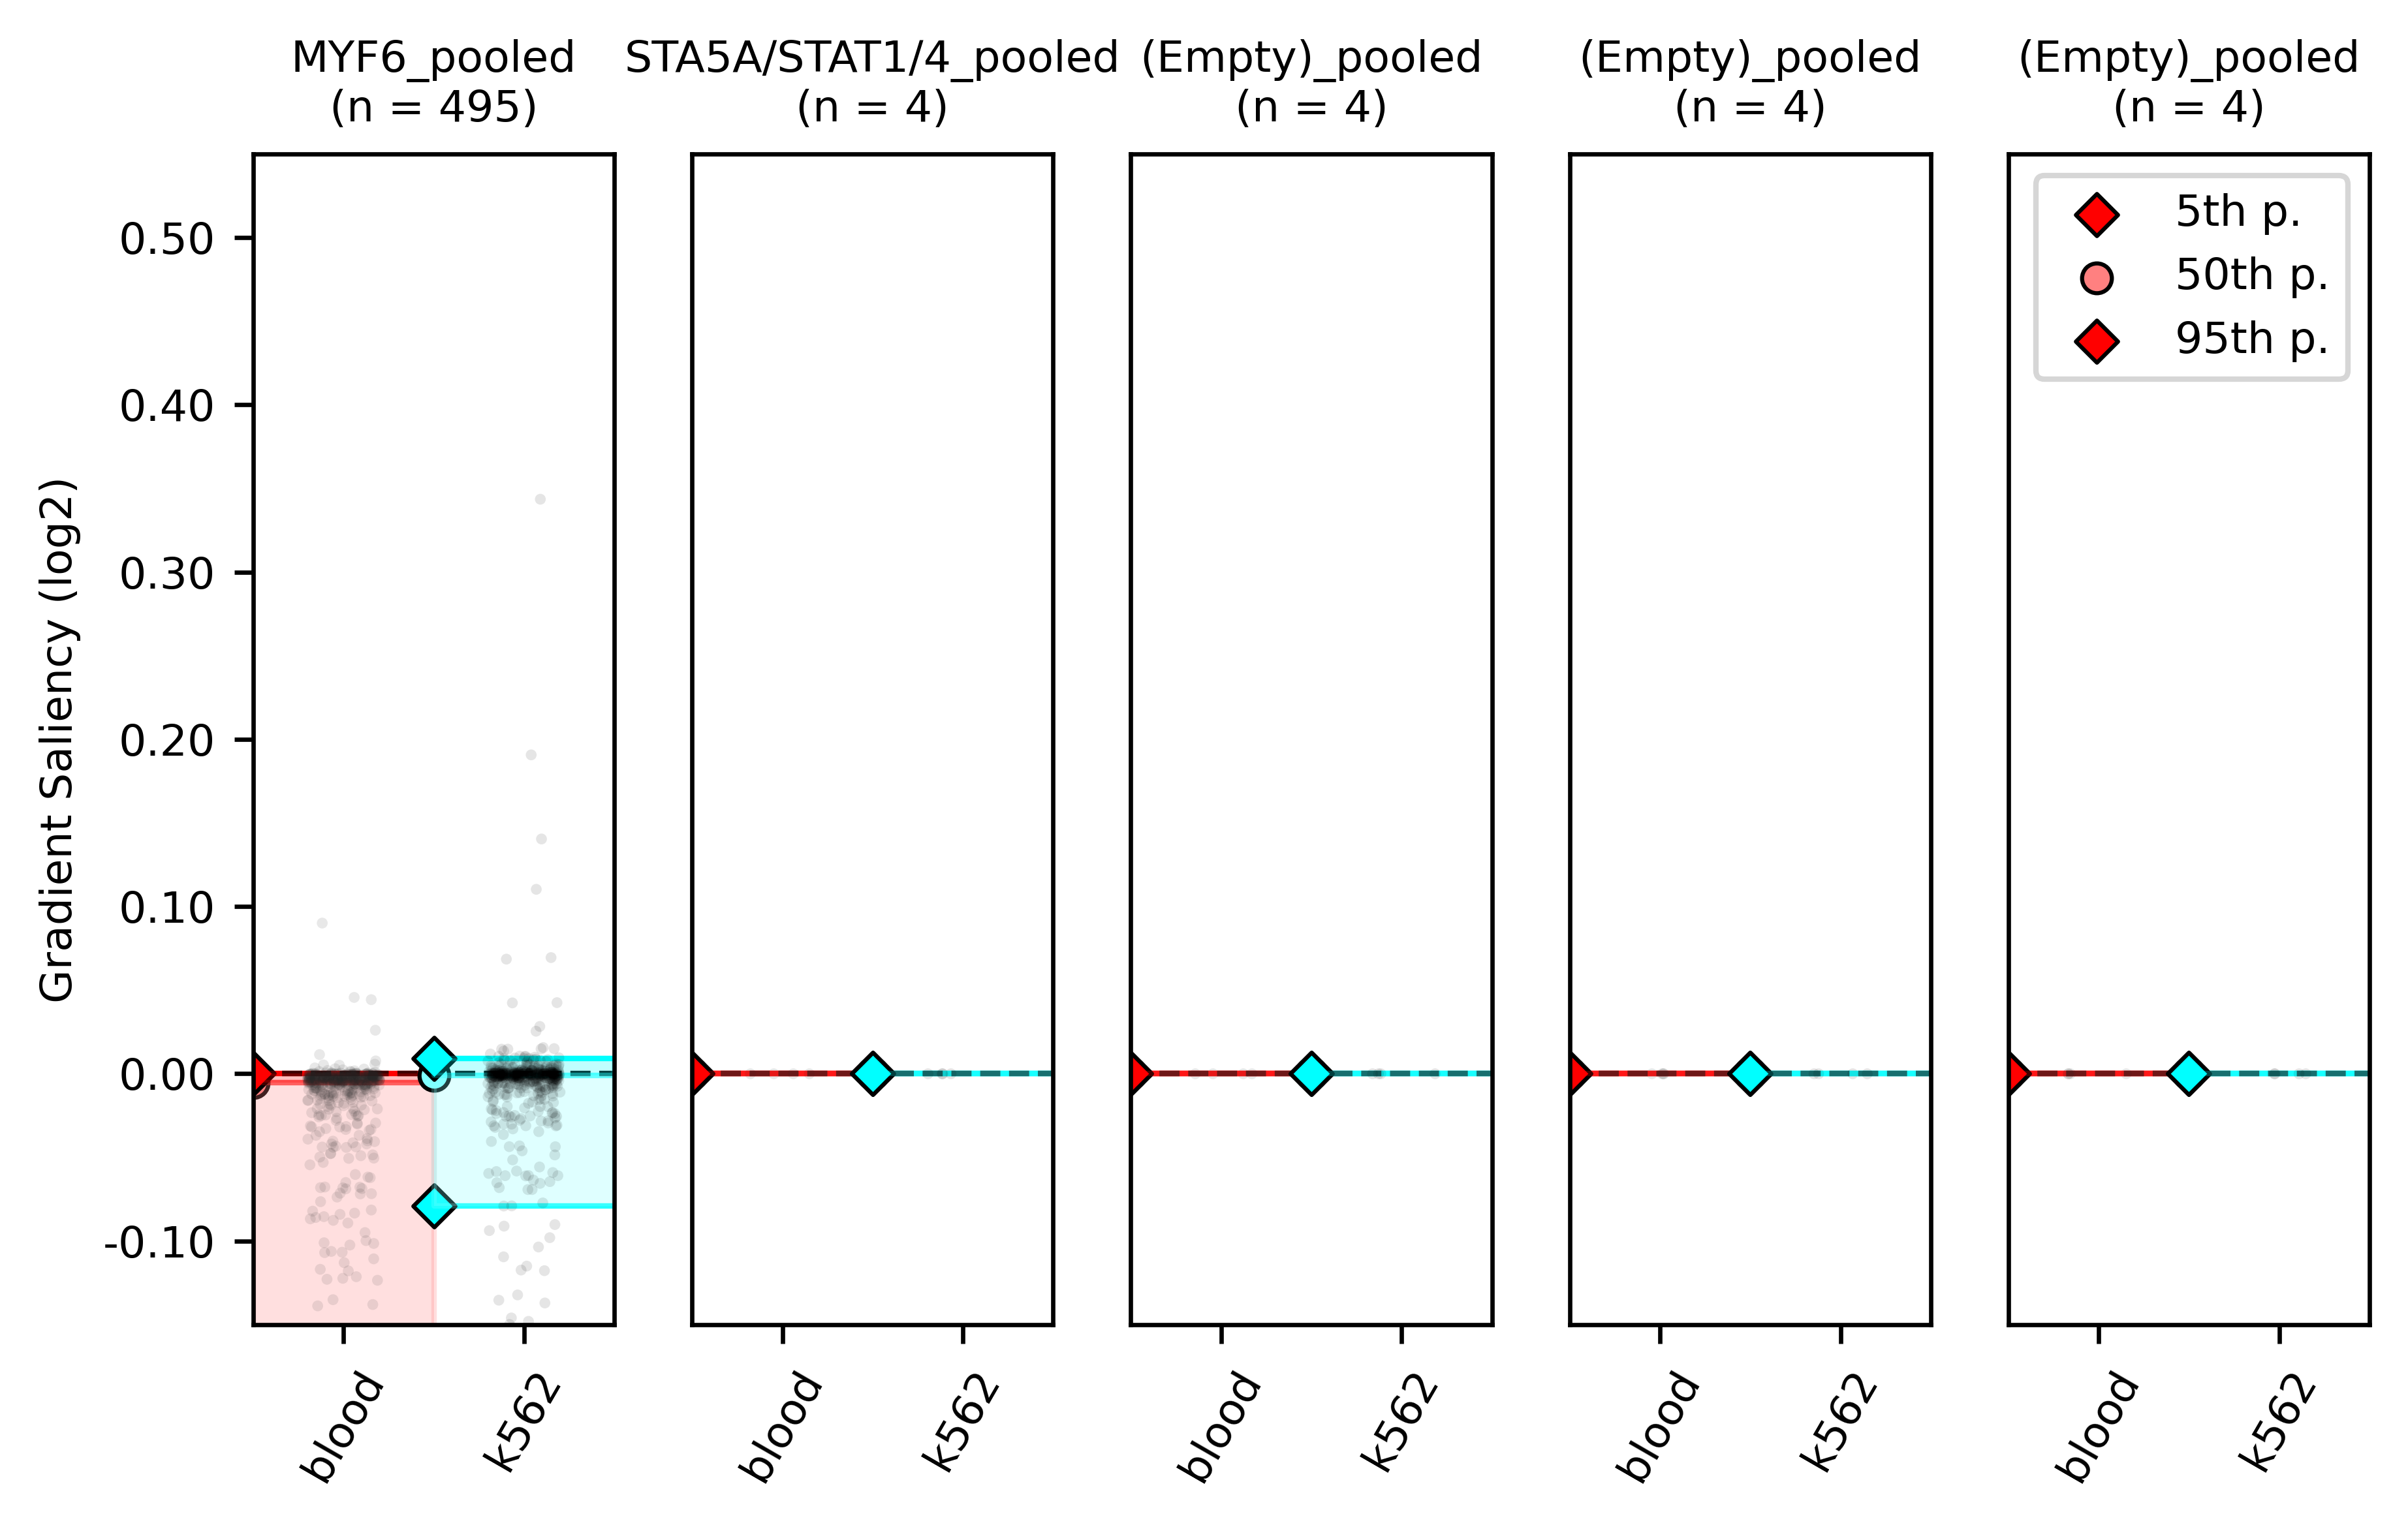

Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4
Motif = '(Empty)_pooled'
 - n = 4


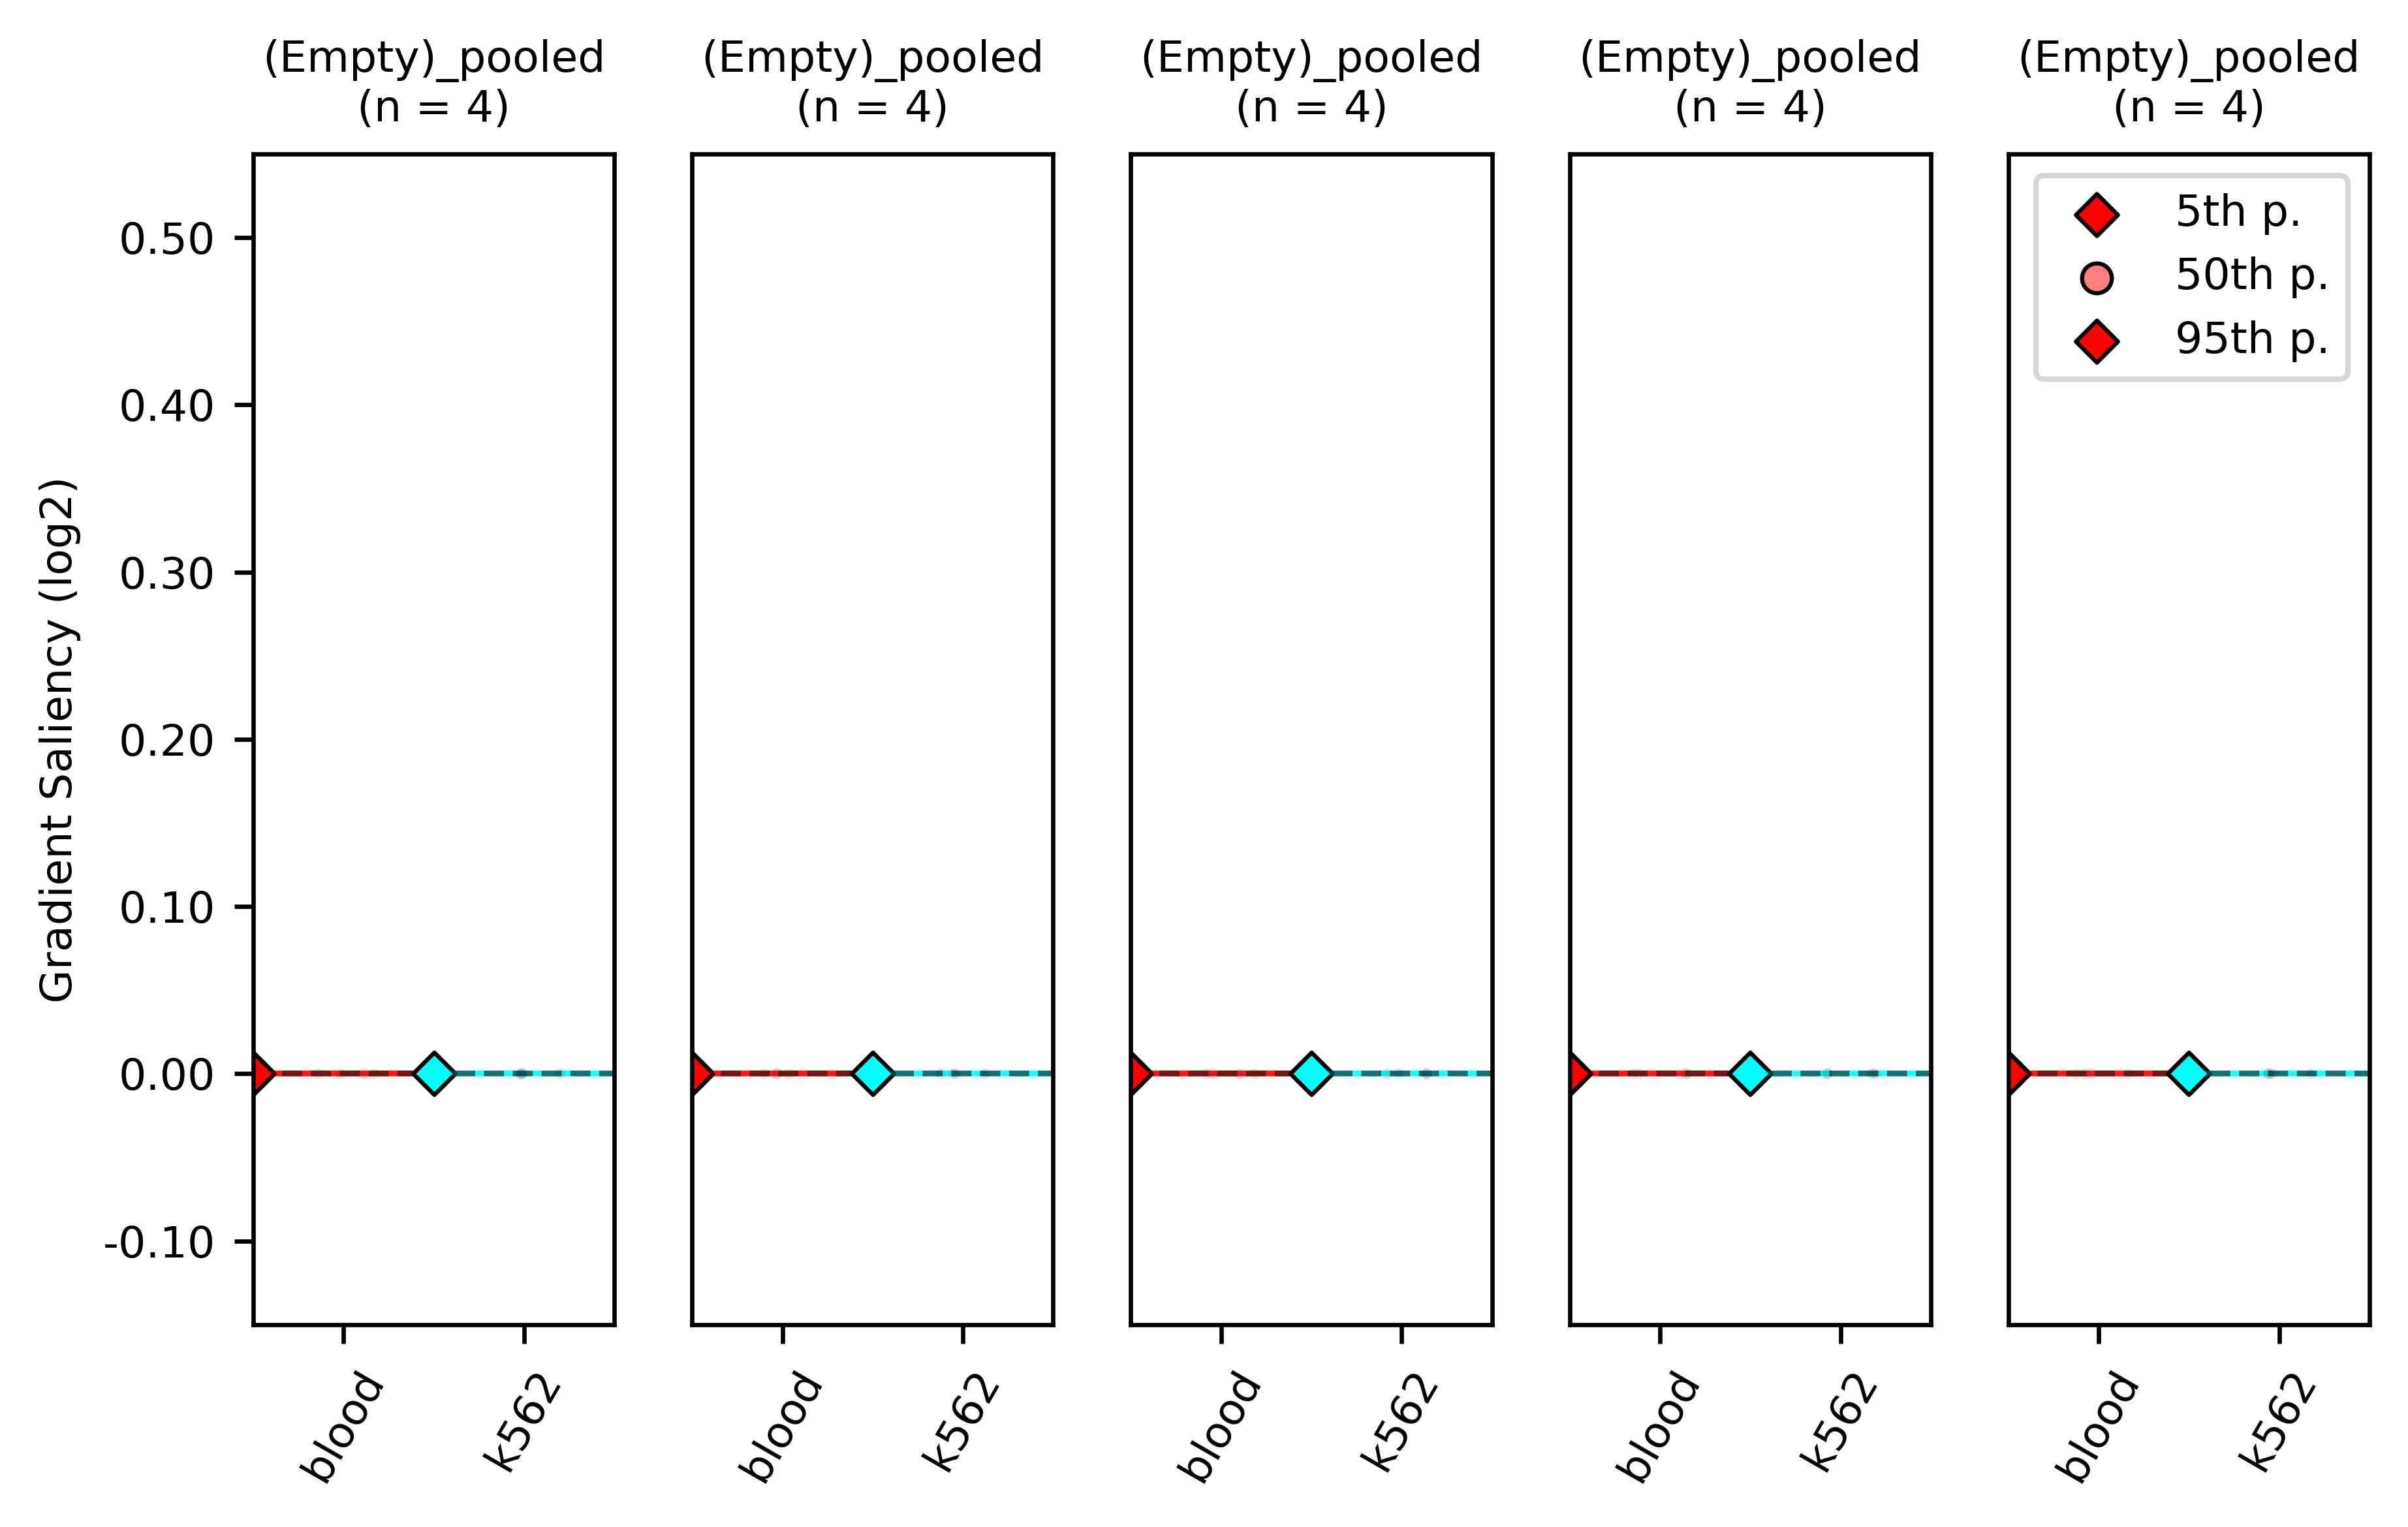

In [8]:
#Interpret pooled genes (rasterize scatter dots)

plot_modisco_interpretation(
    tissue_i=0,
    
    rasterize_dpi=600,
    
    tissue_colors=['red', 'cyan'],
    save_figs=True,
    save_prefix='attribution_figs/modisco_gtex_diff_40k_gaussian_blood_vs_k562_4_folds_diff_auto_tissue_pooled_',
    
    col_width=1.25,
    
    y_min_fixed=-0.15, y_max_fixed=0.55,
    
    qtls=[0.05, 0.50, 0.95],
    shades=[1.0, 0.5, 1.0],
    markers=['D', 'o', 'D'],
)
